# Italian Airports Network - Performance Analysis since 2000  
  
  <br/><br/>

![](images/00_cover.gif?raw=true)

## 01. Exploratory Data Analysis  
  
  <br/><br/>

This is a personal project that aims to analyze the performance of Italian airports in terms of key operational metrics: aircraft movements, passenger traffic, and freight throughput.  
By examining historical data (starting from the year 2000) and identifying trends, my goal is to gain insights into the efficiency, capacity, and potential areas for improvement of different airports.  
  
  The primary data sources for this analysis is [Assaeroporti](https://assaeroporti.com/), the association of Italian airport operators, which collect historical records on aircraft movements, passenger numbers, and freight tonnage.  
  
  After the data collection, I collated and cleaned the different datasets before enriching them with the IATA code and the geographic area for each airport.  
Before performing EDA, there are other potential features that can be added to the dataset:
- geographic coordinates
- potential catchment area (30 minutes, 60 minutes distance)
- distance from closest motorway exit
- distance from closest railway station
- dimensional class
  
  <br/><br/>
  

## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import warnings
import glob
import os

from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import re

from time import time, sleep

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# run to avoid warnings
warnings.filterwarnings('ignore')

## Data Loading

In [4]:
# load the data from the final CSV
df = pd.read_csv('datasets/final/df_fin.csv')

In [5]:
df

,Airport,Code,Geographic Area,Date,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail
0,Alghero,AHO,Islands,2000-01-01,515.0,25.0,0.0,0.0,30634.0,799.0,0.0,0.0,0.0,59.000,0.0000,74.000
1,Ancona,AOI,Central-East,2000-01-01,476.0,346.0,182.0,574.0,18183.0,12098.0,7056.0,61.0,656.0,232.000,2.0000,68.000
2,Bari,BRI,South,2000-01-01,1437.0,77.0,0.0,355.0,82936.0,1217.0,0.0,68.0,110.0,168.000,0.0000,193.000
3,Bergamo,BGY,North-West,2000-01-01,770.0,2302.0,1543.0,216.0,38403.0,48697.0,25666.0,653.0,189.0,7139.000,80.0000,1.000
4,Bologna,BLQ,North-East,2000-01-01,1379.0,3108.0,2576.0,239.0,67923.0,150338.0,120214.0,5424.0,307.0,945.000,422.0000,255.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,Trapani,TPS,Islands,2024-08-01,635.0,308.0,270.0,116.0,90896.0,53226.0,46540.0,125.0,181.0,0.000,0.0000,0.000
10993,Treviso,TSF,North-East,2024-08-01,58.0,1610.0,1275.0,270.0,8858.0,286104.0,227946.0,180.0,281.0,0.000,0.0000,0.000
10994,Trieste,TRS,North-East,2024-08-01,556.0,446.0,381.0,193.0,68278.0,64413.0,53494.0,24.0,206.0,6.249,0.2630,0.000
10995,Venezia,VCE,North-East,2024-08-01,1500.0,6493.0,4496.0,642.0,230856.0,974277.0,610136.0,1199.0,1379.0,4527.423,564.7301,0.091


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10997 entries, 0 to 10996
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Airport              10997 non-null  object 
 1   Code                 10997 non-null  object 
 2   Geographic Area      10997 non-null  object 
 3   Date                 10997 non-null  object 
 4   MOV - Domestic       10953 non-null  float64
 5   MOV - International  10953 non-null  float64
 6   MOV - EU             10917 non-null  float64
 7   MOV - General Avio   10953 non-null  float64
 8   PAX - Domestic       10953 non-null  float64
 9   PAX - International  10953 non-null  float64
 10  PAX - EU             10917 non-null  float64
 11  PAX - Transit        10953 non-null  float64
 12  PAX - General Avio   10953 non-null  float64
 13  FRE - Goods Avio     10950 non-null  float64
 14  FRE - Goods Ground   9421 non-null   float64
 15  FRE - Mail           10950 non-null 

In [7]:
# transform the Date column into DateTime format
df['Date'] = pd.to_datetime(df.Date)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10997 entries, 0 to 10996
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Airport              10997 non-null  object        
 1   Code                 10997 non-null  object        
 2   Geographic Area      10997 non-null  object        
 3   Date                 10997 non-null  datetime64[ns]
 4   MOV - Domestic       10953 non-null  float64       
 5   MOV - International  10953 non-null  float64       
 6   MOV - EU             10917 non-null  float64       
 7   MOV - General Avio   10953 non-null  float64       
 8   PAX - Domestic       10953 non-null  float64       
 9   PAX - International  10953 non-null  float64       
 10  PAX - EU             10917 non-null  float64       
 11  PAX - Transit        10953 non-null  float64       
 12  PAX - General Avio   10953 non-null  float64       
 13  FRE - Goods Avio     10950 non-

In [9]:
# make the Date column the index of the dataframe
df.set_index(keys='Date', inplace=True)

In [10]:
# create Month and Year columns from the DateTime index
df['Month'] = df.index.month
df['Year'] = df.index.year

In [11]:
# reorder columns
col = df.pop('Month')
df.insert(3, col.name, col)

col = df.pop('Year')
df.insert(4, col.name, col)

In [12]:
df

,Airport,Code,Geographic Area,Month,Year,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail
Date,,,,,,,,,,,,,,,,,
2000-01-01,Alghero,AHO,Islands,1,2000,515.0,25.0,0.0,0.0,30634.0,799.0,0.0,0.0,0.0,59.000,0.0000,74.000
2000-01-01,Ancona,AOI,Central-East,1,2000,476.0,346.0,182.0,574.0,18183.0,12098.0,7056.0,61.0,656.0,232.000,2.0000,68.000
2000-01-01,Bari,BRI,South,1,2000,1437.0,77.0,0.0,355.0,82936.0,1217.0,0.0,68.0,110.0,168.000,0.0000,193.000
2000-01-01,Bergamo,BGY,North-West,1,2000,770.0,2302.0,1543.0,216.0,38403.0,48697.0,25666.0,653.0,189.0,7139.000,80.0000,1.000
2000-01-01,Bologna,BLQ,North-East,1,2000,1379.0,3108.0,2576.0,239.0,67923.0,150338.0,120214.0,5424.0,307.0,945.000,422.0000,255.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,Trapani,TPS,Islands,8,2024,635.0,308.0,270.0,116.0,90896.0,53226.0,46540.0,125.0,181.0,0.000,0.0000,0.000
2024-08-01,Treviso,TSF,North-East,8,2024,58.0,1610.0,1275.0,270.0,8858.0,286104.0,227946.0,180.0,281.0,0.000,0.0000,0.000
2024-08-01,Trieste,TRS,North-East,8,2024,556.0,446.0,381.0,193.0,68278.0,64413.0,53494.0,24.0,206.0,6.249,0.2630,0.000


In [13]:
# df['Year'] = df['Date'].dt.month

In [14]:
# define subsets for aircraft movements
mov_dom_year = df.groupby('Year')['MOV - Domestic'].sum().reset_index()
mov_int_year = df.groupby('Year')['MOV - International'].sum().reset_index()
mov_EU_year = df.groupby('Year')['MOV - EU'].sum().reset_index()
mov_gen_year = df.groupby('Year')['MOV - General Avio'].sum().reset_index()

# define subsets for passengers 
pax_dom_year = df.groupby('Year')['PAX - Domestic'].sum().reset_index()
pax_int_year = df.groupby('Year')['PAX - International'].sum().reset_index()
pax_EU_year = df.groupby('Year')['PAX - EU'].sum().reset_index()
pax_trs_year = df.groupby('Year')['PAX - Transit'].sum().reset_index()
pax_gen_year = df.groupby('Year')['PAX - General Avio'].sum().reset_index()

# define subsets for freight
fre_avio_year = df.groupby('Year')['FRE - Goods Avio'].sum().reset_index()
fre_grnd_year = df.groupby('Year')['FRE - Goods Ground'].sum().reset_index()
fre_mail_year = df.groupby('Year')['FRE - Mail'].sum().reset_index()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


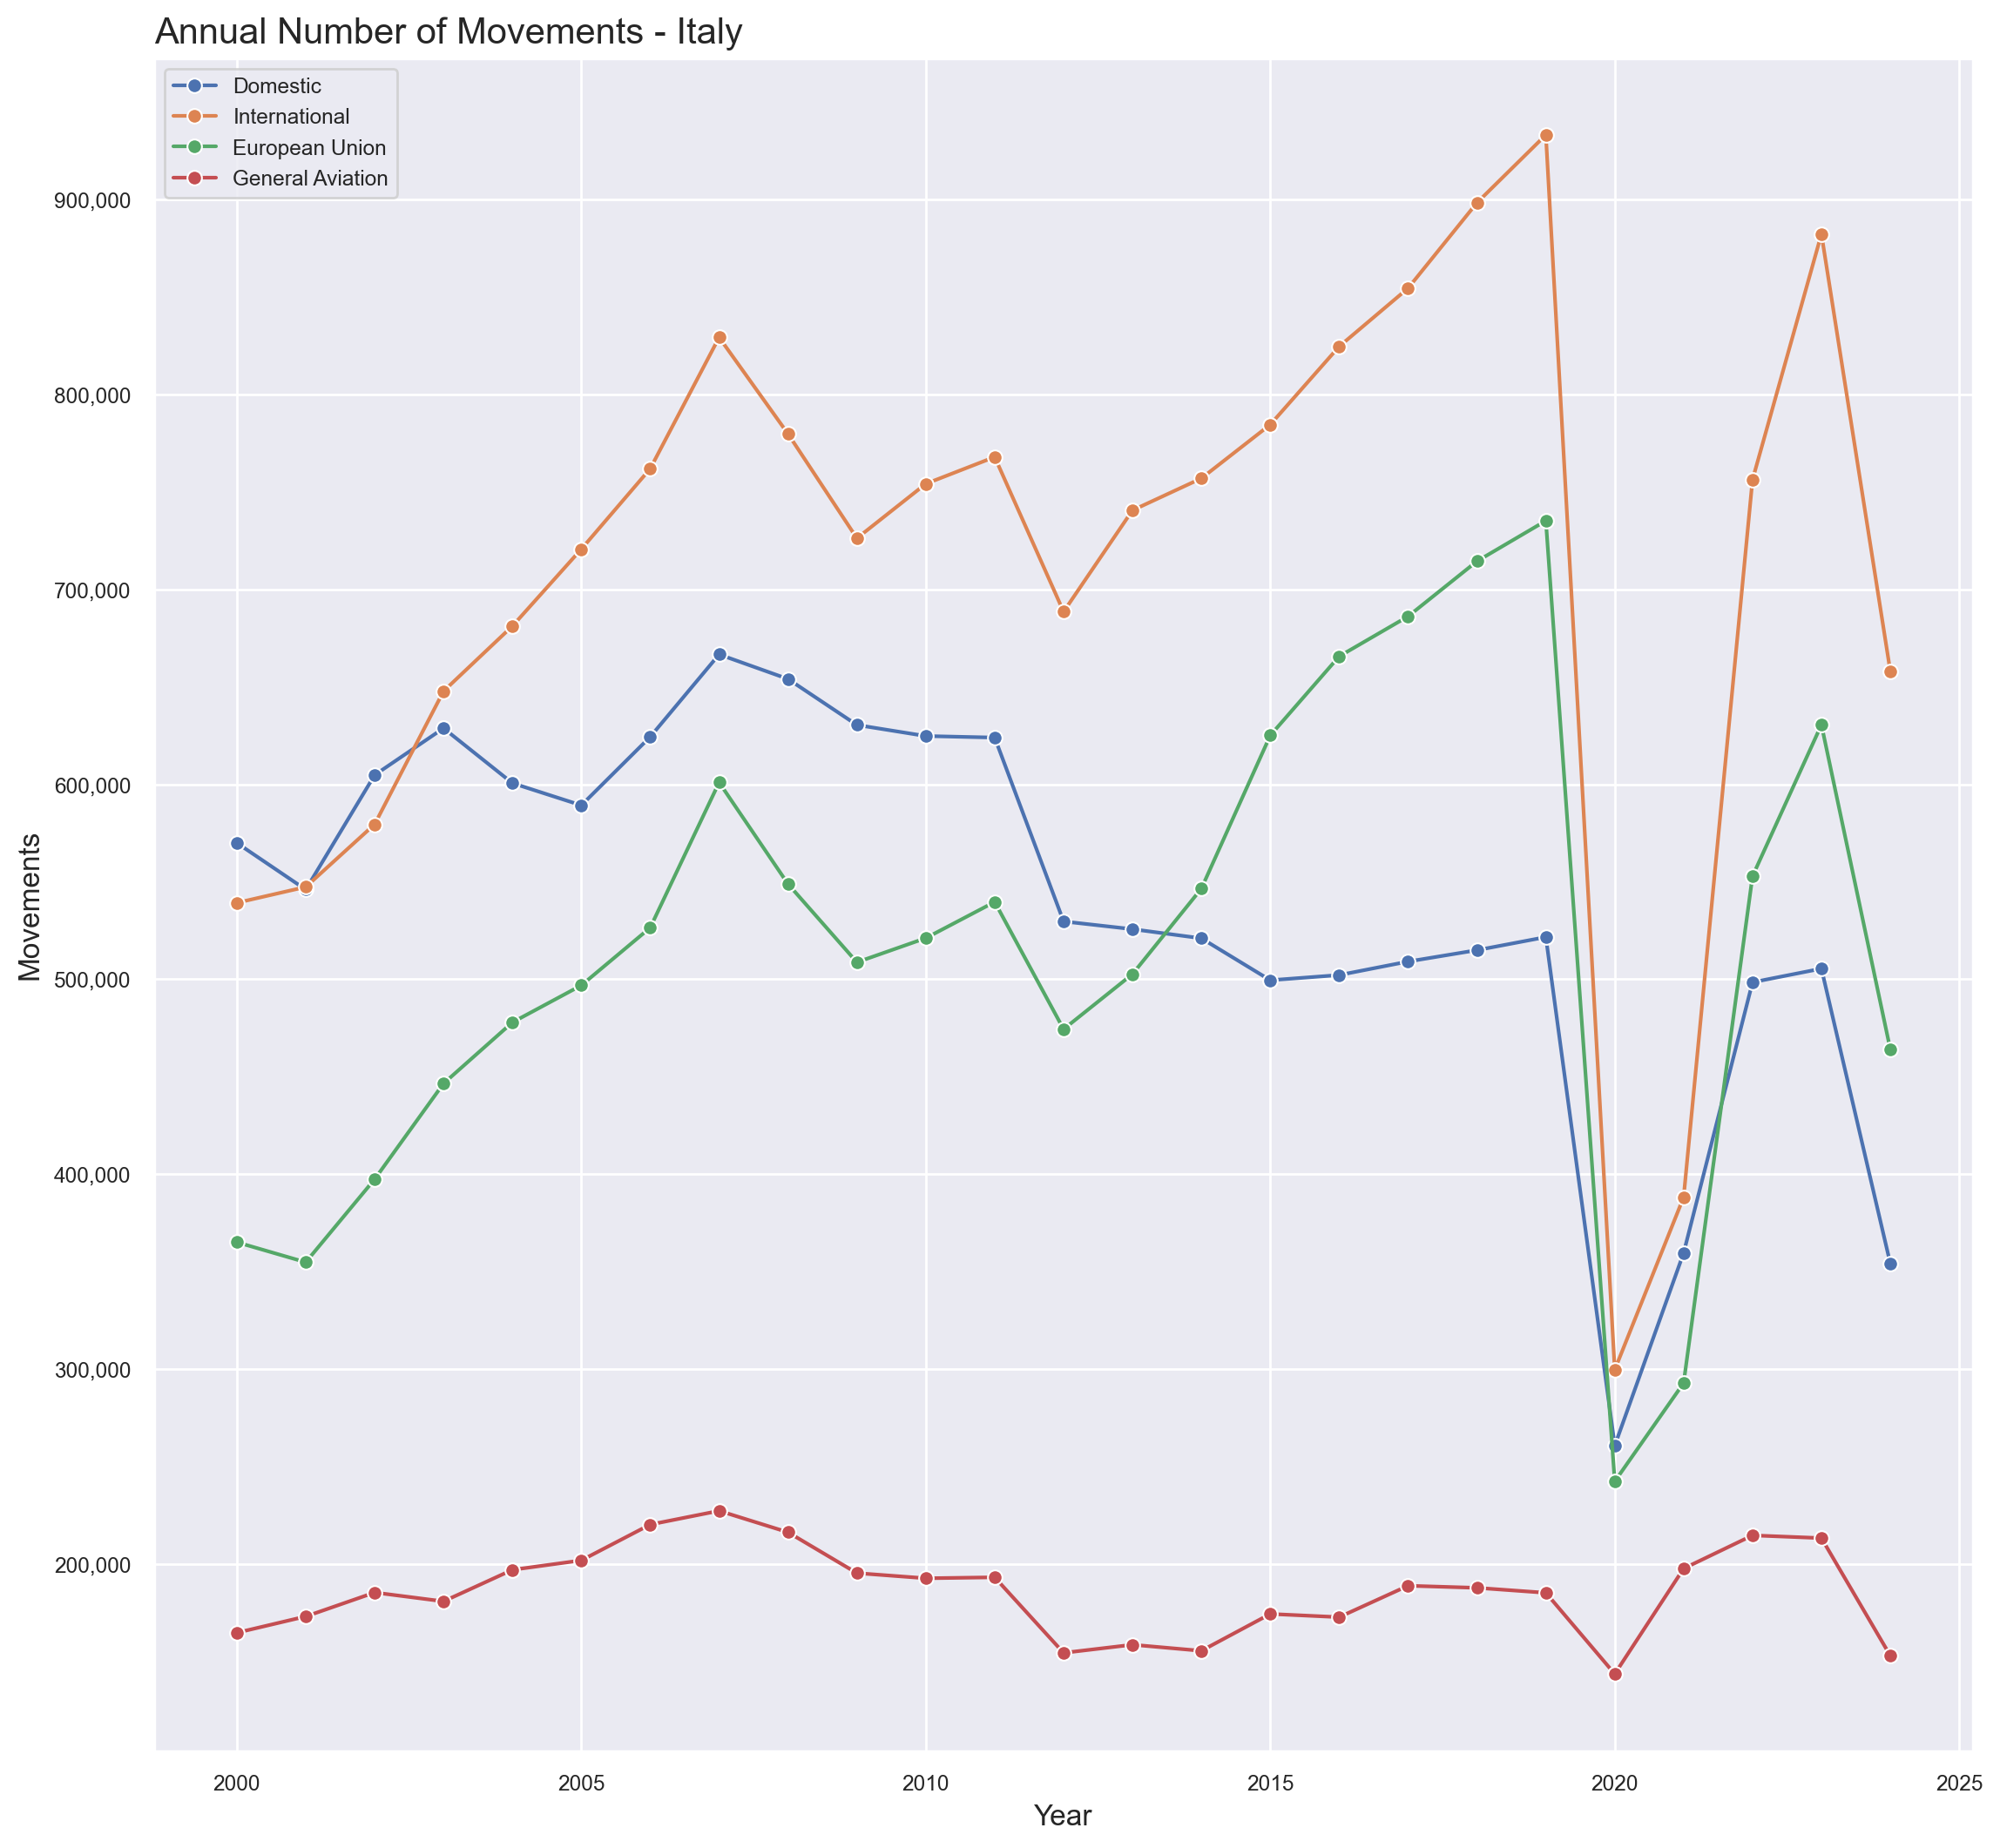

In [15]:
# plot the movements time series
fig, ax = plt.subplots(figsize = (12,12))
plt.title('Annual Number of Movements - Italy', loc='left', fontsize = 15)
plt.xticks(rotation = 0)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Movements', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(loc="upper left")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.lineplot(data=mov_dom_year, x='Year', y='MOV - Domestic', marker='o', label='Domestic')
sns.lineplot(data=mov_int_year, x='Year', y='MOV - International', marker='o', label='International')
sns.lineplot(data=mov_EU_year, x='Year', y='MOV - EU', marker='o', label='European Union')
sns.lineplot(data=mov_gen_year, x='Year', y='MOV - General Avio', marker='o', label='General Aviation')

plt.legend(loc="upper left")
plt.show()

The movements concerning the **European Union** are a subset of the **International** ones and both follow a similar pattern.  
**Domestic** movements were the highest segment in 2000, peaked in 2007 but declined after 2011.  
The movements concerning **General Aviation** are significantly lower than the other segments as expected.  
The negative impact of COVID is clearly visible for every segment during the years 2020 and 2021.  
  
  <br/><br/>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


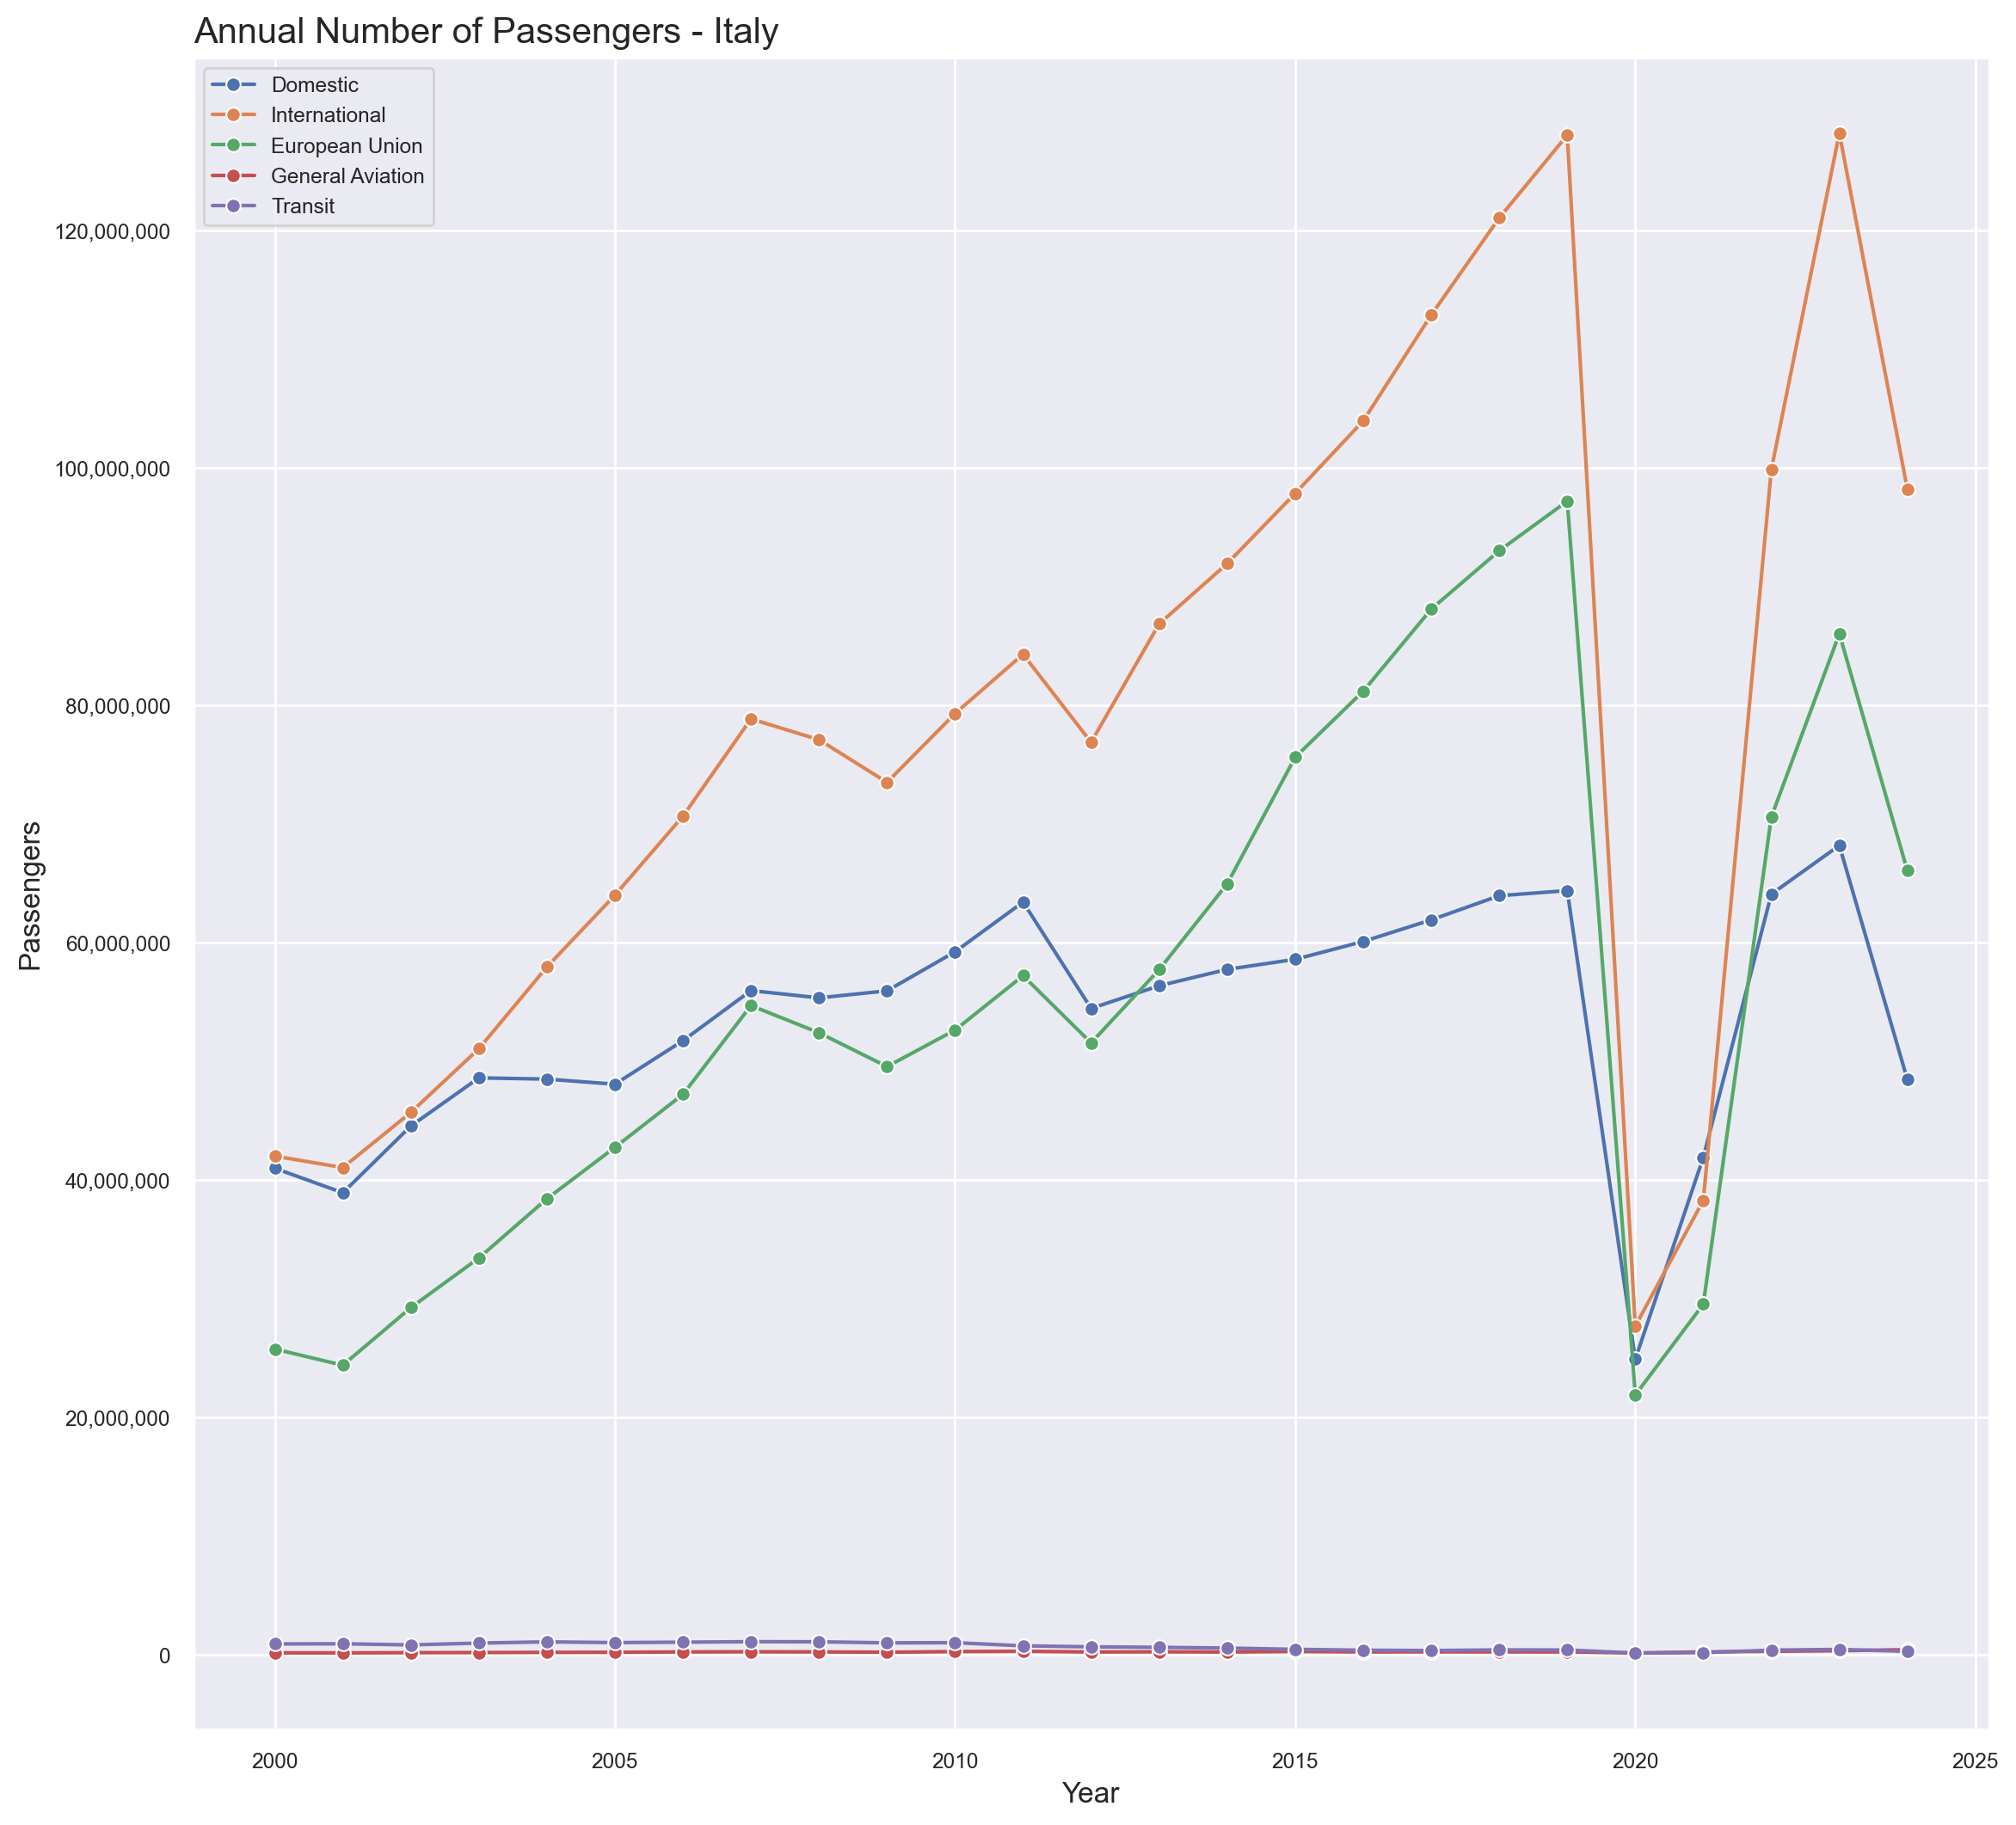

In [16]:
# plot the passengers time series
fig, ax = plt.subplots(figsize = (12,12))
plt.title('Annual Number of Passengers - Italy', loc='left', fontsize = 15)
plt.xticks(rotation = 0)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Passengers', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(loc="upper left")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.lineplot(data=pax_dom_year, x='Year', y='PAX - Domestic', marker='o', label='Domestic')
sns.lineplot(data=pax_int_year, x='Year', y='PAX - International', marker='o', label='International')
sns.lineplot(data=pax_EU_year, x='Year', y='PAX - EU', marker='o', label='European Union')
sns.lineplot(data=pax_gen_year, x='Year', y='PAX - General Avio', marker='o', label='General Aviation')
sns.lineplot(data=pax_trs_year, x='Year', y='PAX - Transit', marker='o', label='Transit')

plt.show()

The passengers concerning the **European Union** are a subset of the **International** ones and both follow a similar pattern.  
**Domestic** passengers numbers remained similar to the **International** ones until 2003, when they started to diverge and became half of the latter.  
The negative impact of COVID is clearly visible for every segment during the years 2020 and 2021.  
  
  <br/><br/>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


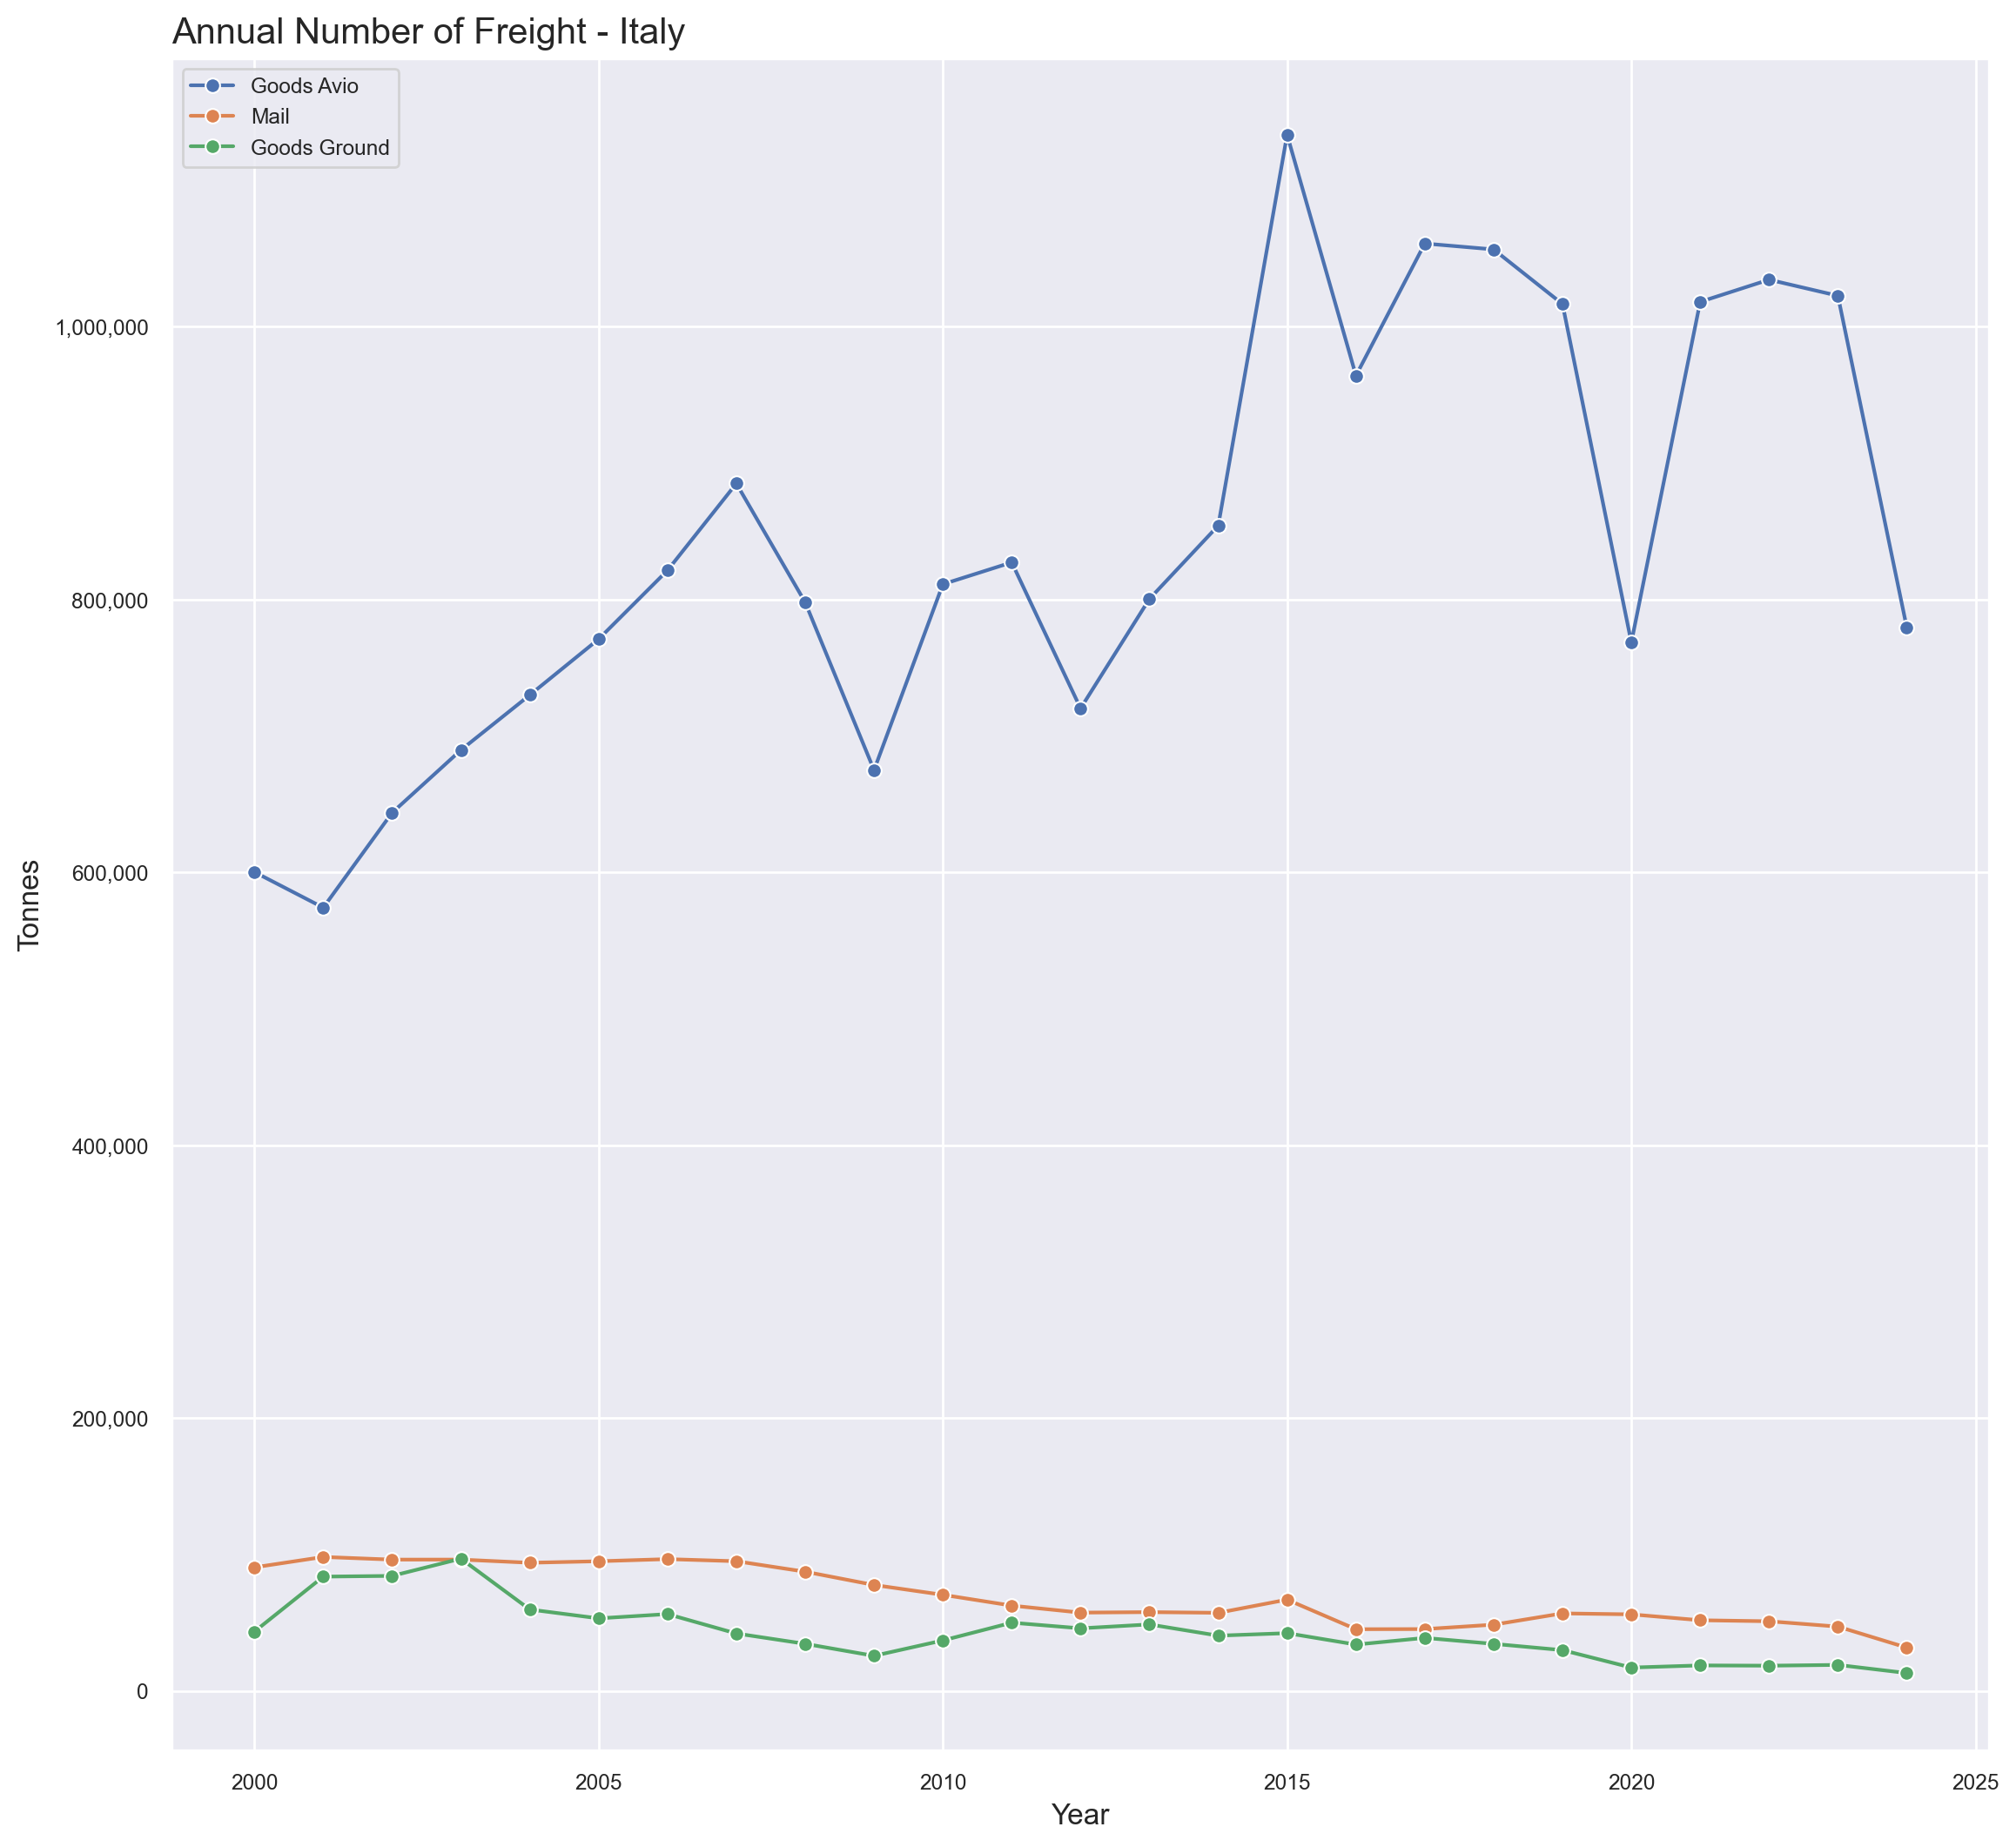

In [17]:
# plot the freight time series
fig, ax = plt.subplots(figsize = (12,12))
plt.title('Annual Number of Freight - Italy', loc='left', fontsize = 15)
plt.xticks(rotation = 0)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Tonnes', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(loc="upper left")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.lineplot(data=fre_avio_year, x='Year', y='FRE - Goods Avio', marker='o', label='Goods Avio')
sns.lineplot(data=fre_mail_year, x='Year', y='FRE - Mail', marker='o', label='Mail')
sns.lineplot(data=fre_grnd_year, x='Year', y='FRE - Goods Ground', marker='o', label='Goods Ground')

plt.legend(loc="upper left")
plt.show()

**Goods Avio** generally shows an upward trend, although there are several fluctuations: it peaked in 2015 and its lows are linked to years of economic downturns.    
**Mail** and **Goods Ground** have significantly lower levels of activity and show a negative trend.   
  
  <br/><br/>



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


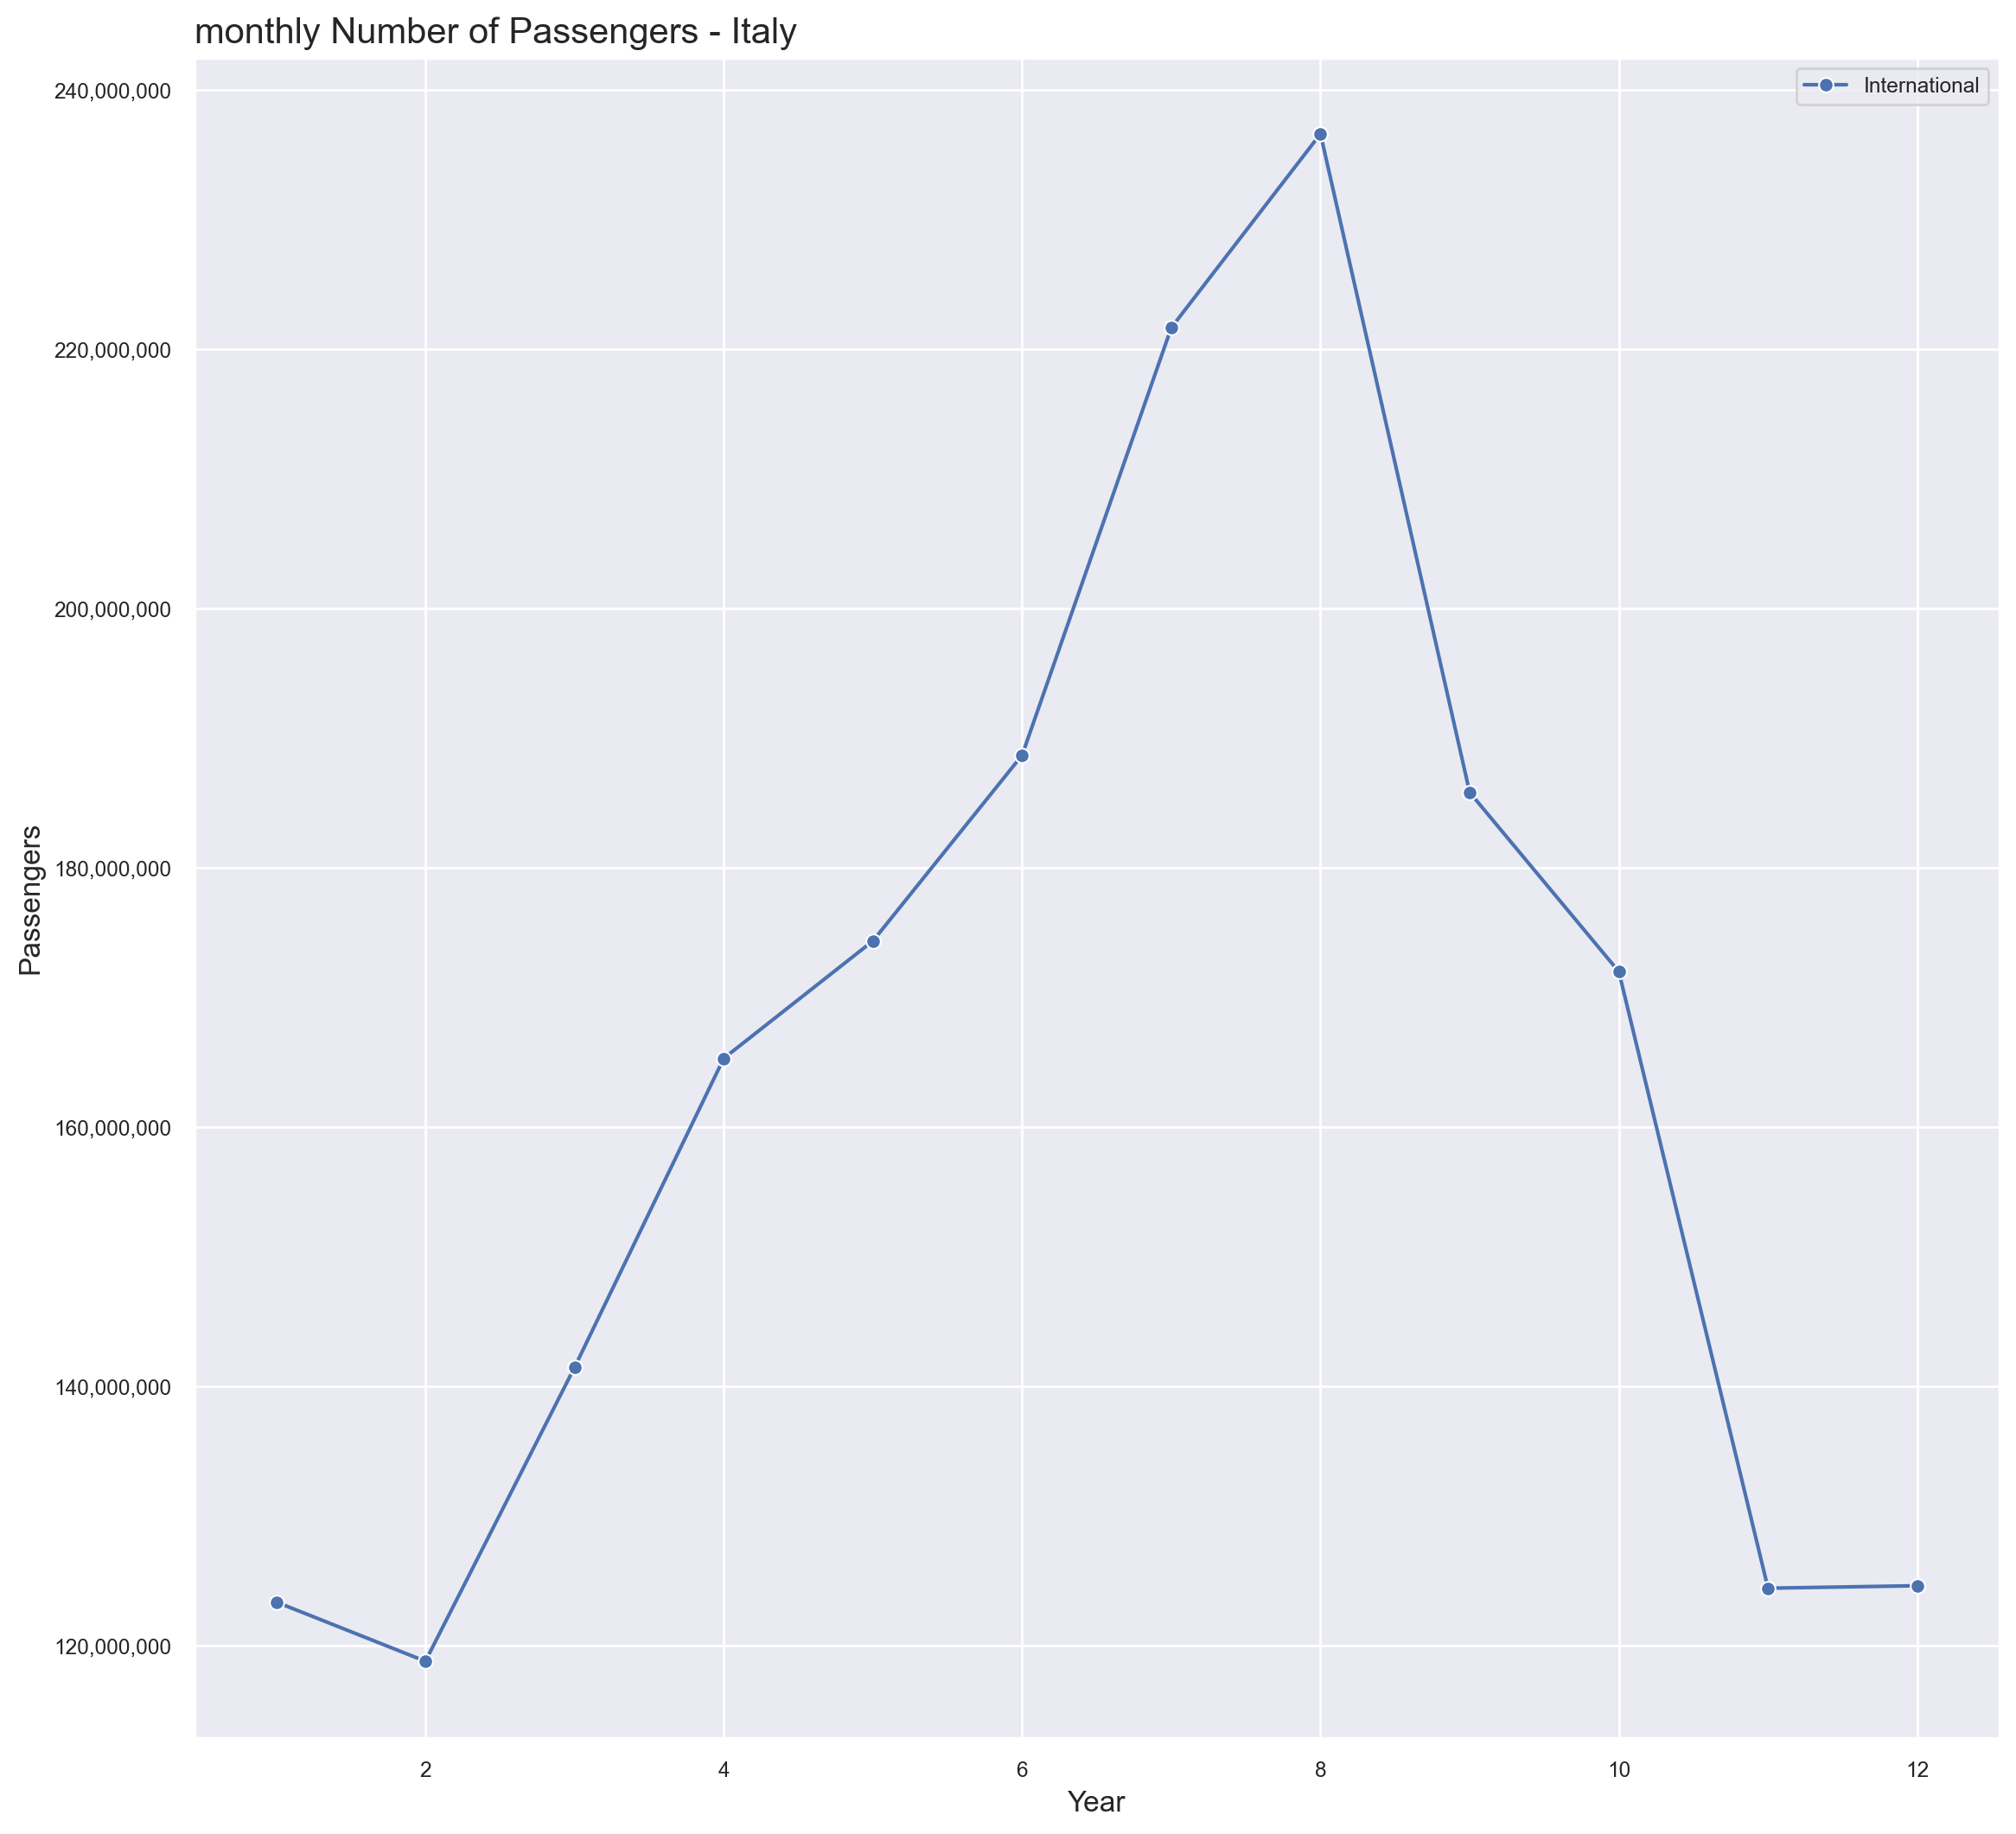

In [18]:
df.groupby('Month')['MOV - International'].sum().reset_index()



# plot the passengers time series
fig, ax = plt.subplots(figsize = (12,12))
plt.title('monthly Number of Passengers - Italy', loc='left', fontsize = 15)
plt.xticks(rotation = 0)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Passengers', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(loc="upper left")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.lineplot(data=df.groupby('Month')['PAX - International'].sum().reset_index(), x='Month', y='PAX - International', marker='o', label='International')


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: Could not interpret value `Year` for parameter `hue`

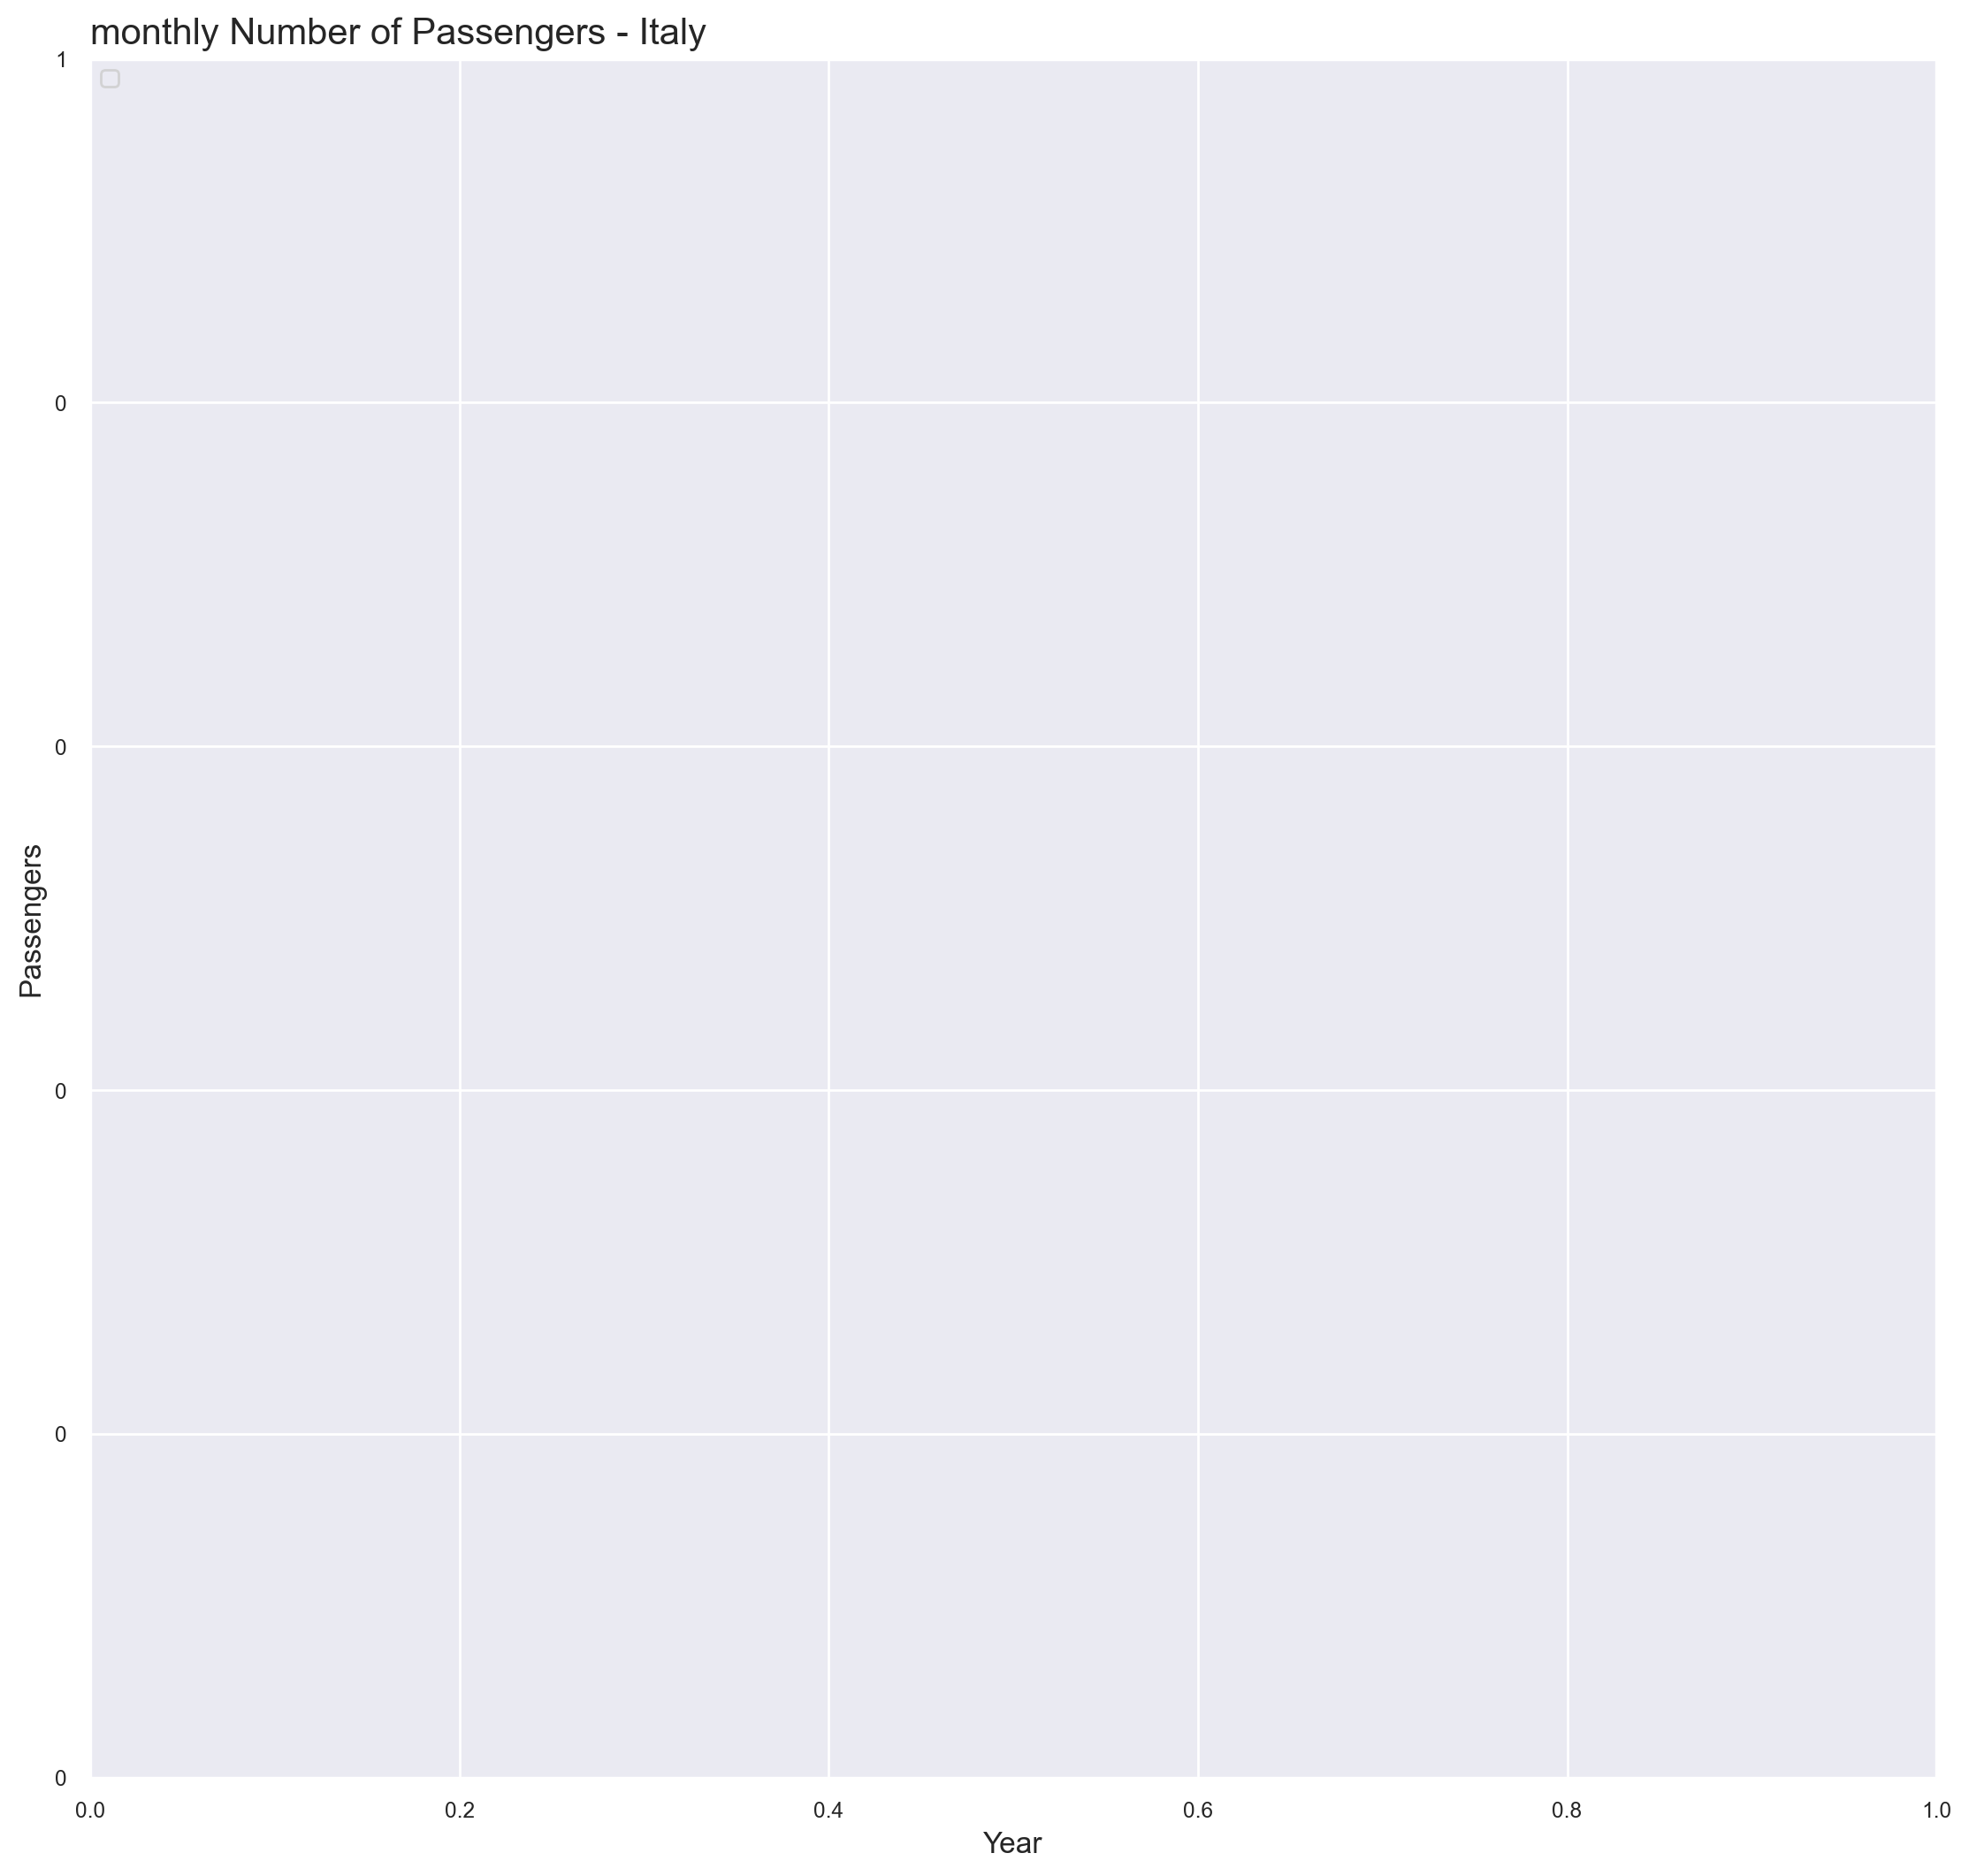

In [21]:
df.groupby('Month')['MOV - International'].sum().reset_index()



# plot the passengers time series
fig, ax = plt.subplots(figsize = (12,12))
plt.title('monthly Number of Passengers - Italy', loc='left', fontsize = 15)
plt.xticks(rotation = 0)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Passengers', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.legend(loc="upper left")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.lineplot(data=df.groupby('Month')['PAX - International'].sum().reset_index(), x='Month', y='PAX - International',
             hue='Year', marker='o', label='International')

plt.show()

ValueError: cannot reindex on an axis with duplicate labels

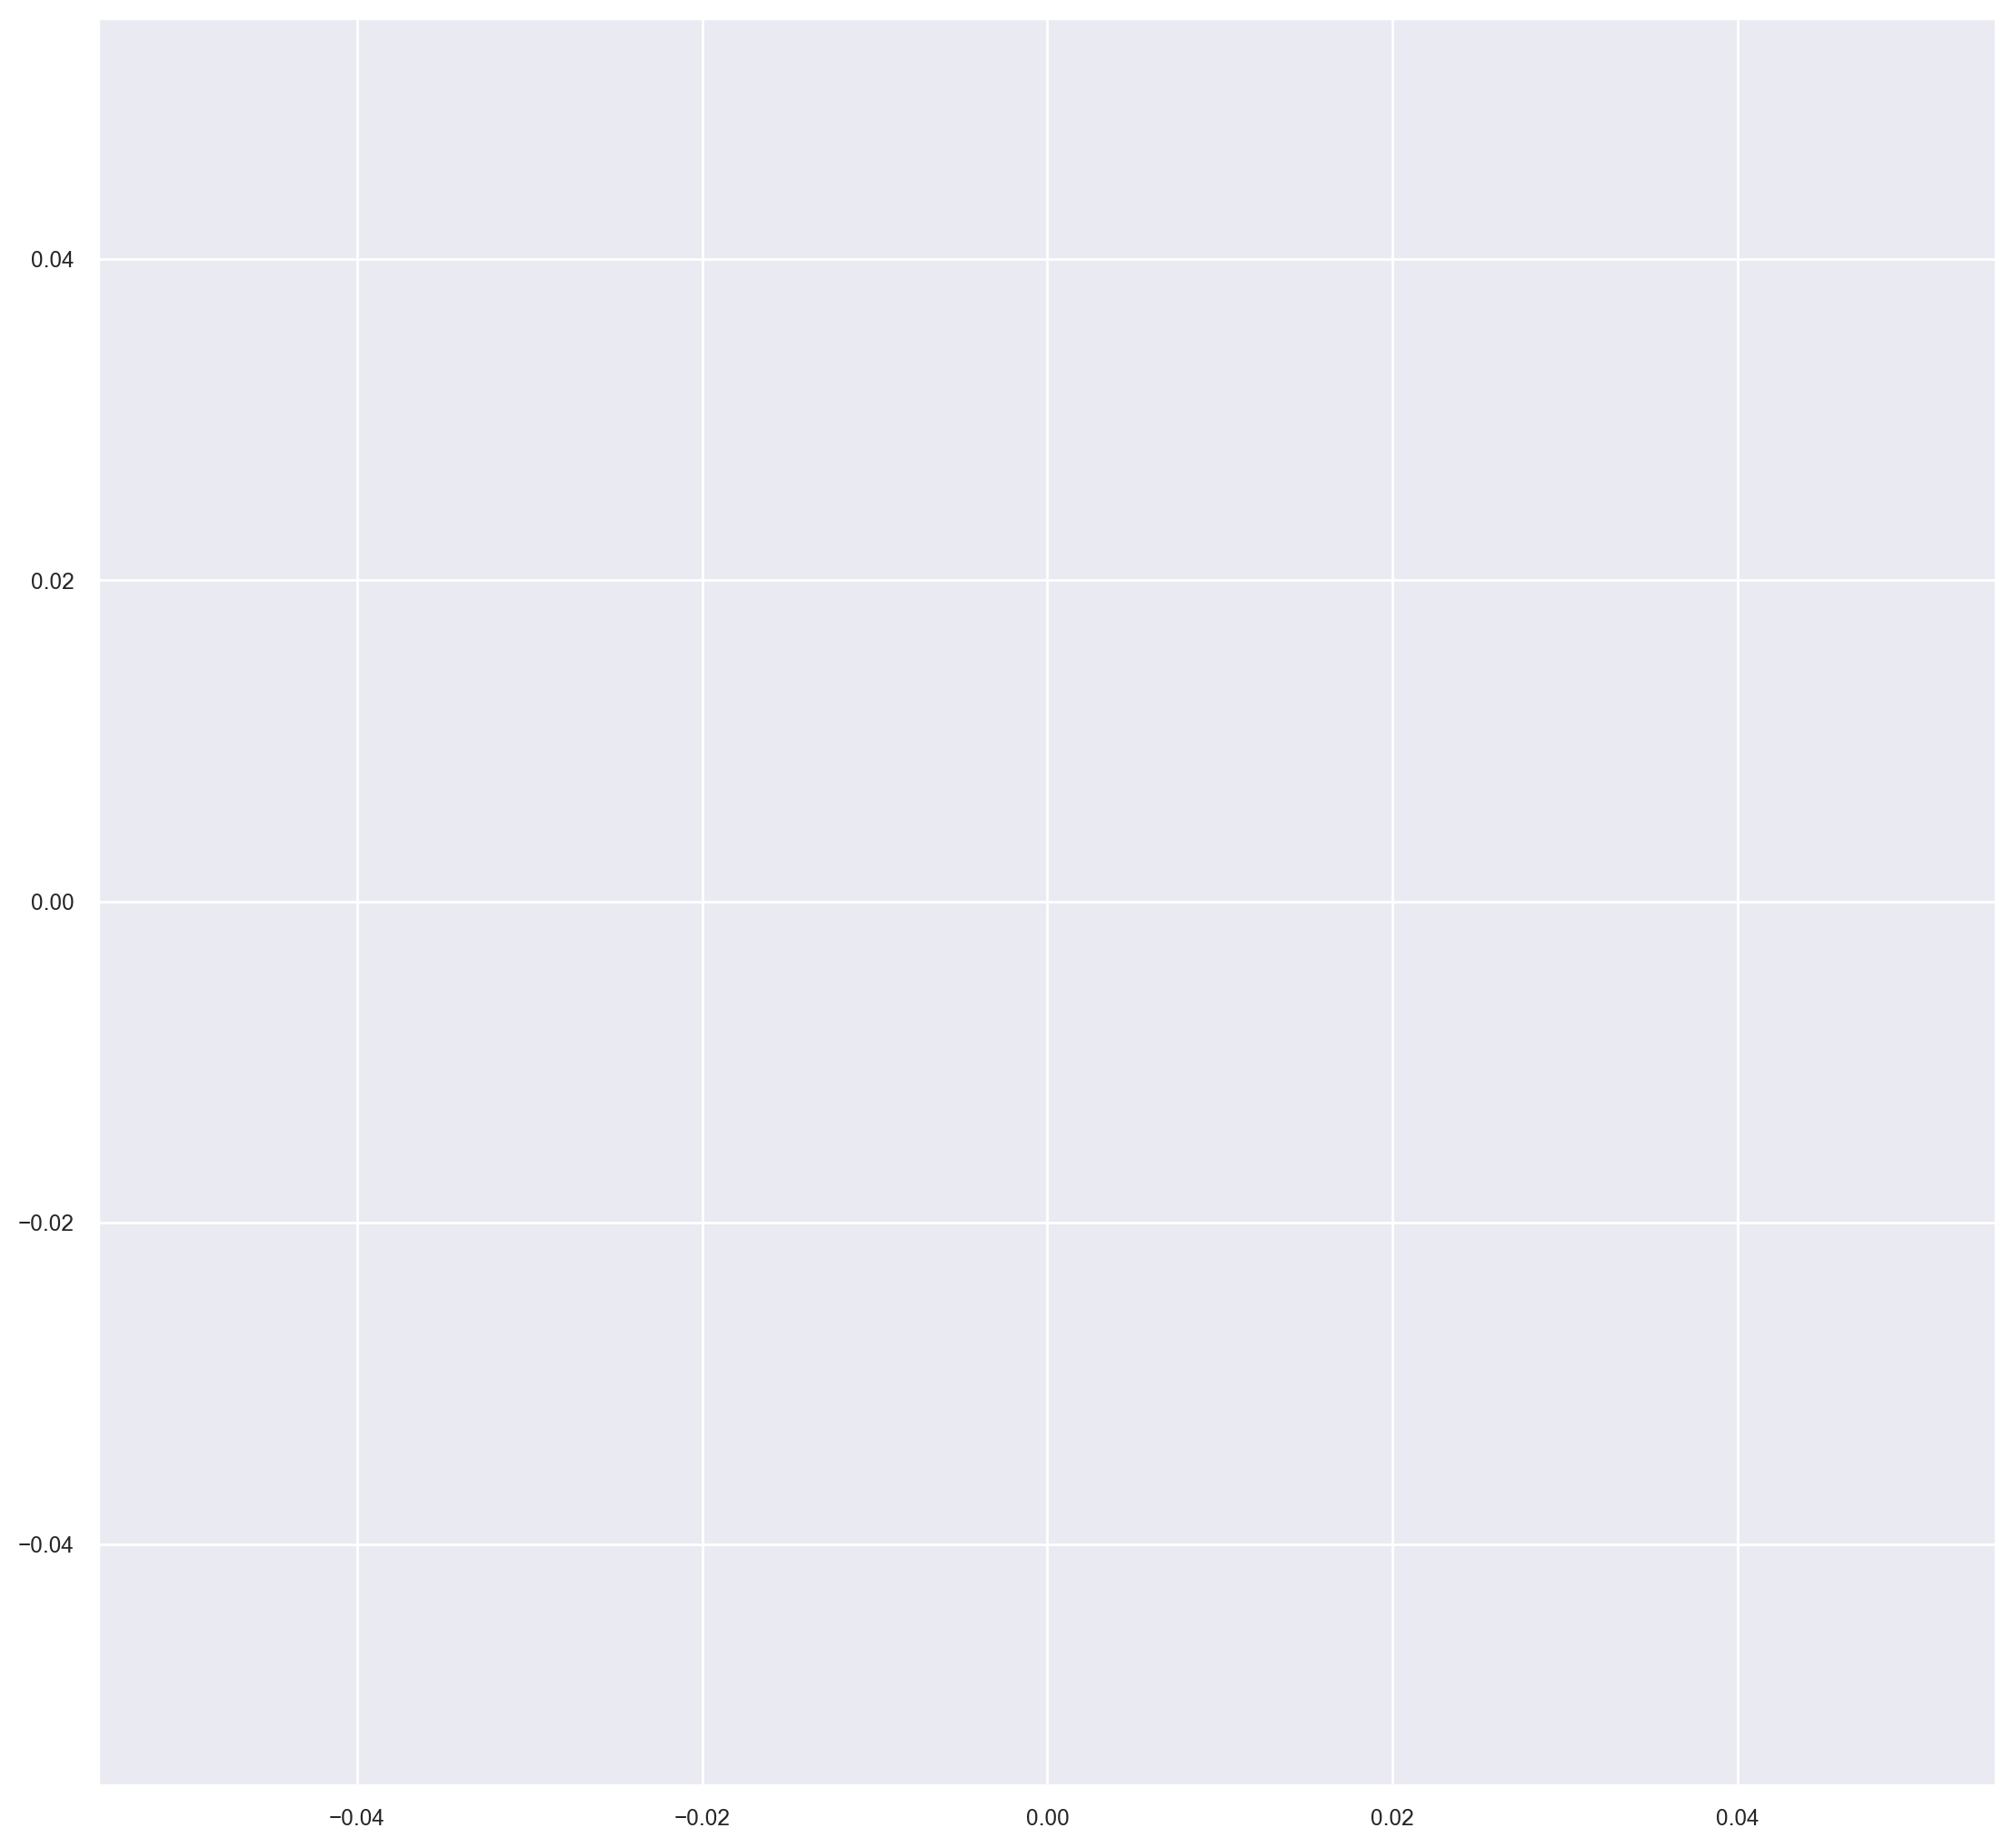

In [20]:
# Sample time series data (data to be replaced)
# data = {'Date': pd.date_range(start='2018-01-01', end='2023-12-31', freq='M'),
#         'Value': [i for i in range(72)]}
# df = pd.DataFrame(data)

# Group data by month and year
# df['Year'] = df['Date'].dt.year
# df['Month'] = df['Date'].dt.month

# Create a line plot using Seaborn
plt.figure(figsize=(12, 12))
sns.lineplot(x='Month', y='PAX - Domestic', hue='Year', data=df, marker='o')

# Customize the plot
plt.title('Monthly Trend Over Years')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

plt.show()

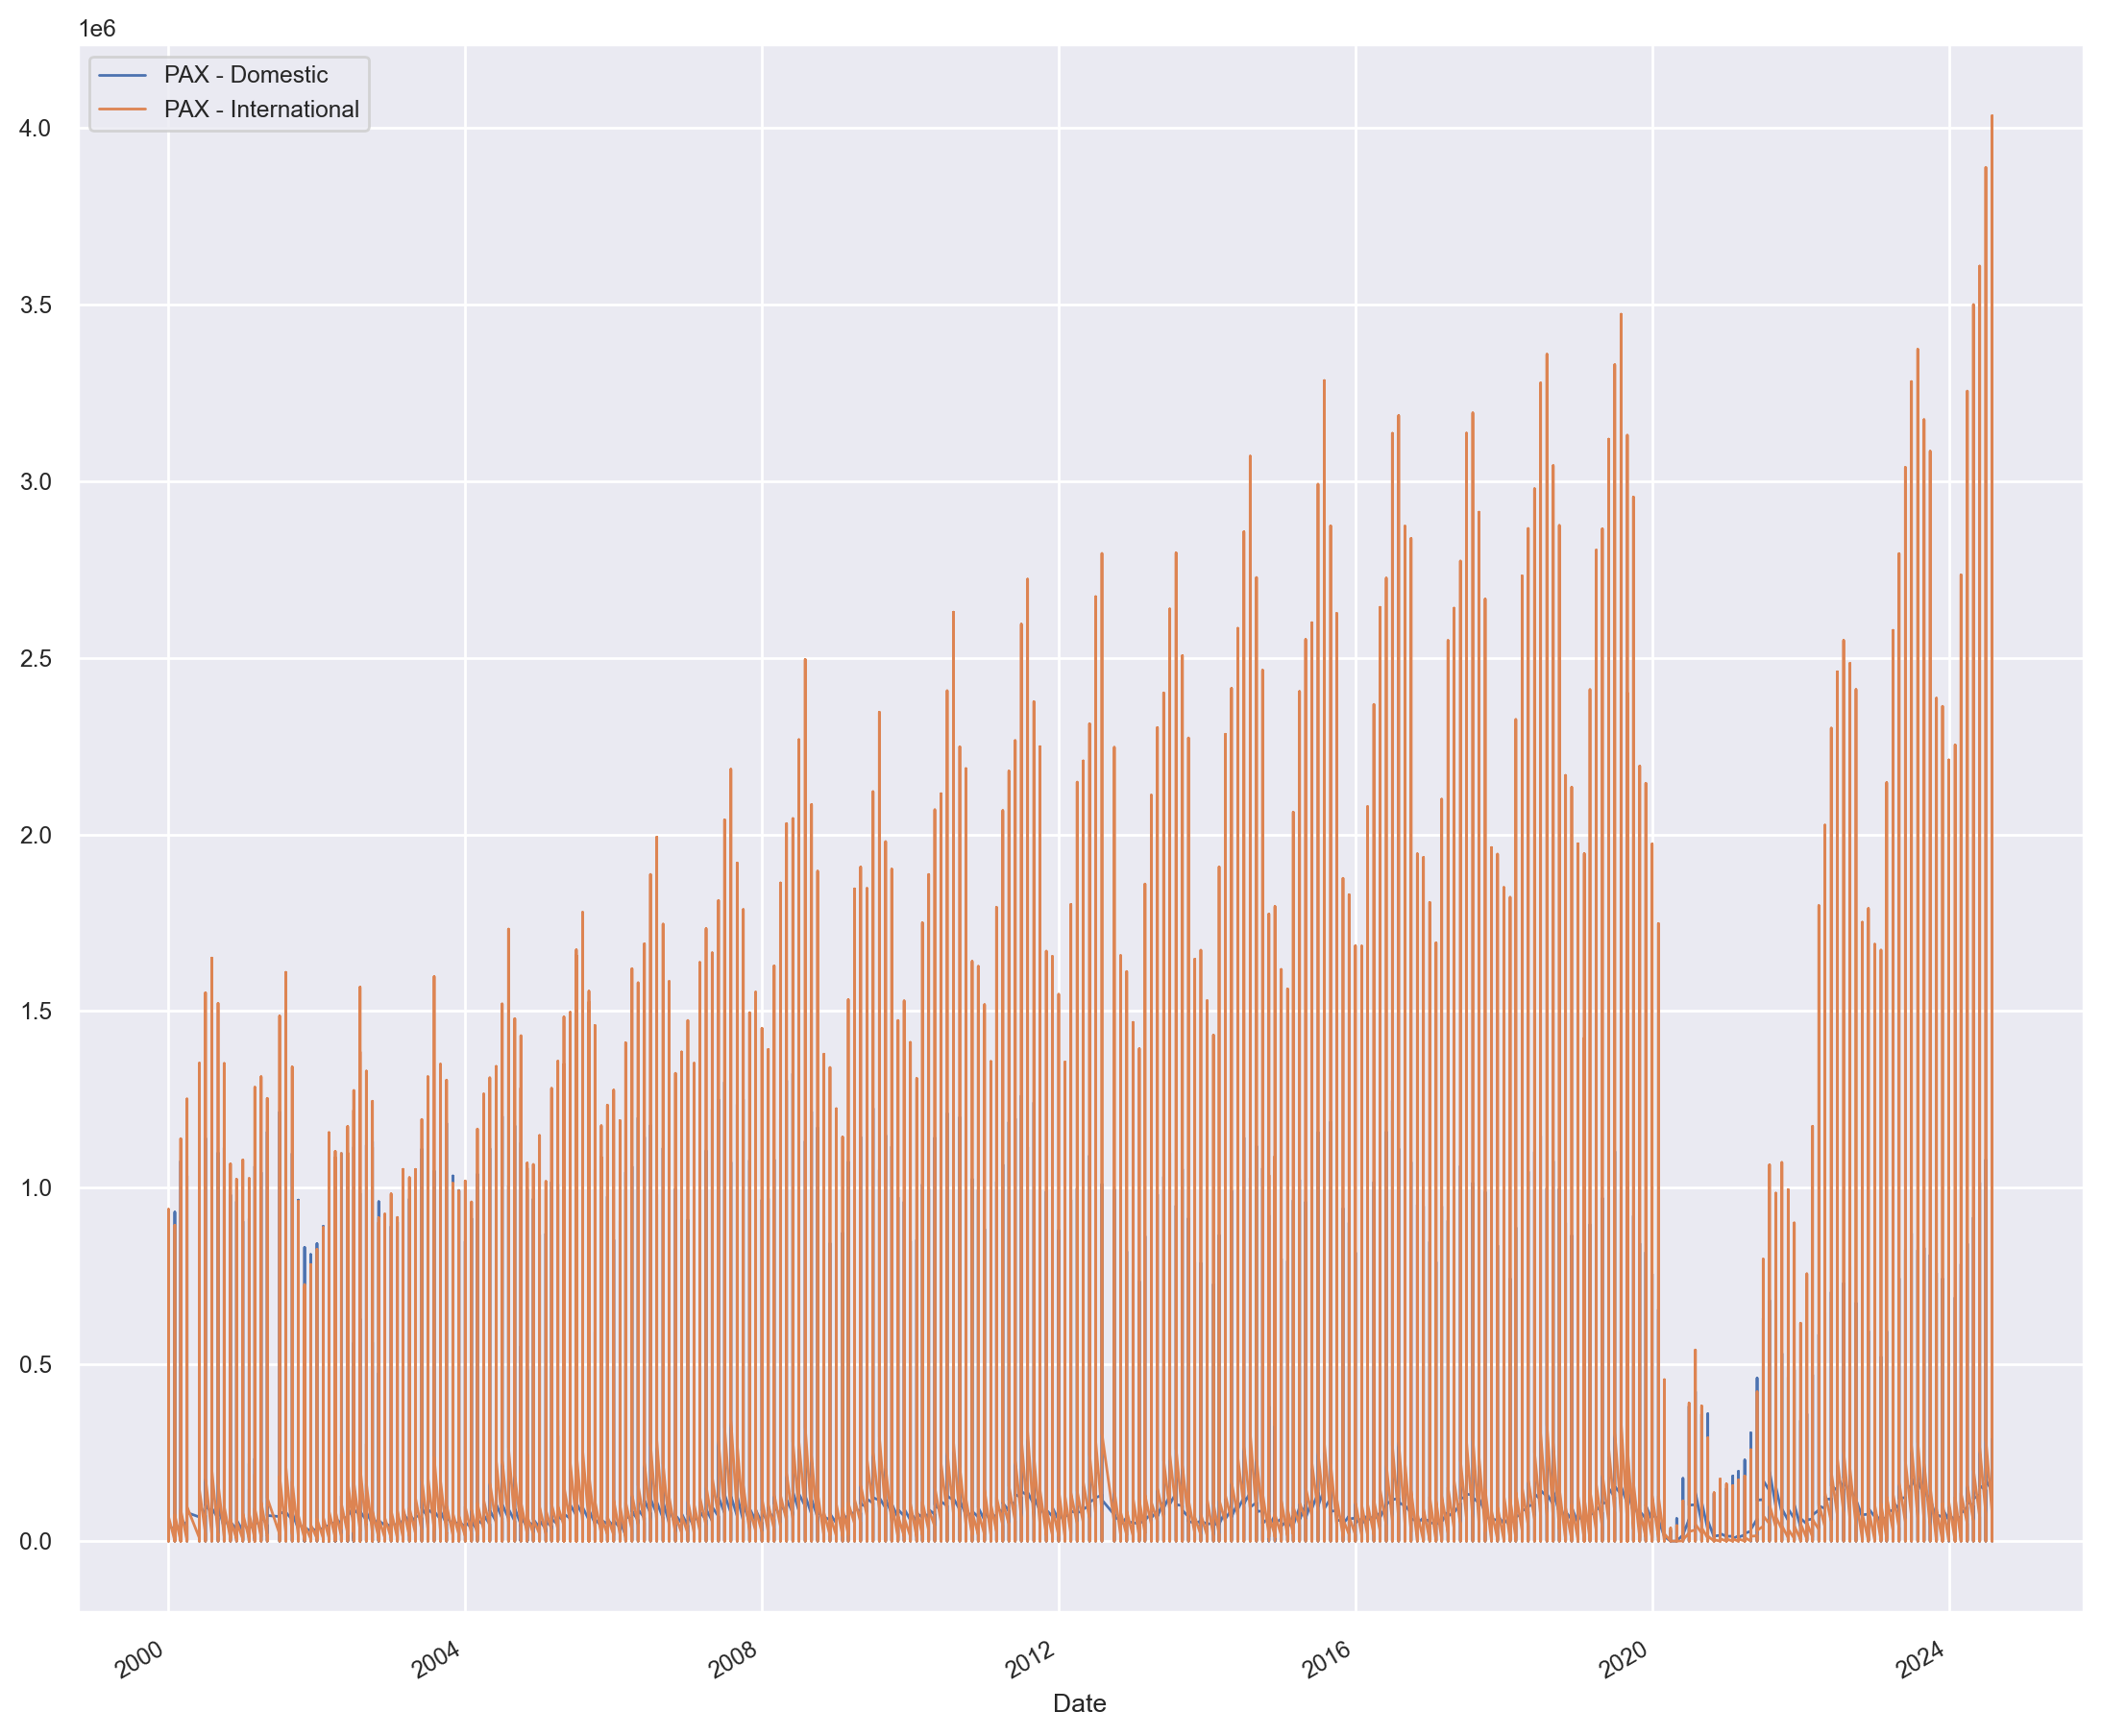

In [14]:

df.plot(y = ['PAX - Domestic', 'PAX - International'],
        figsize=(12, 12), linewidth=1);

In [40]:
may_flights = df.query("Month == 5")
AOI_flights = df.query("Code == 'AOI'")

<AxesSubplot:xlabel='Year', ylabel='PAX - Domestic'>

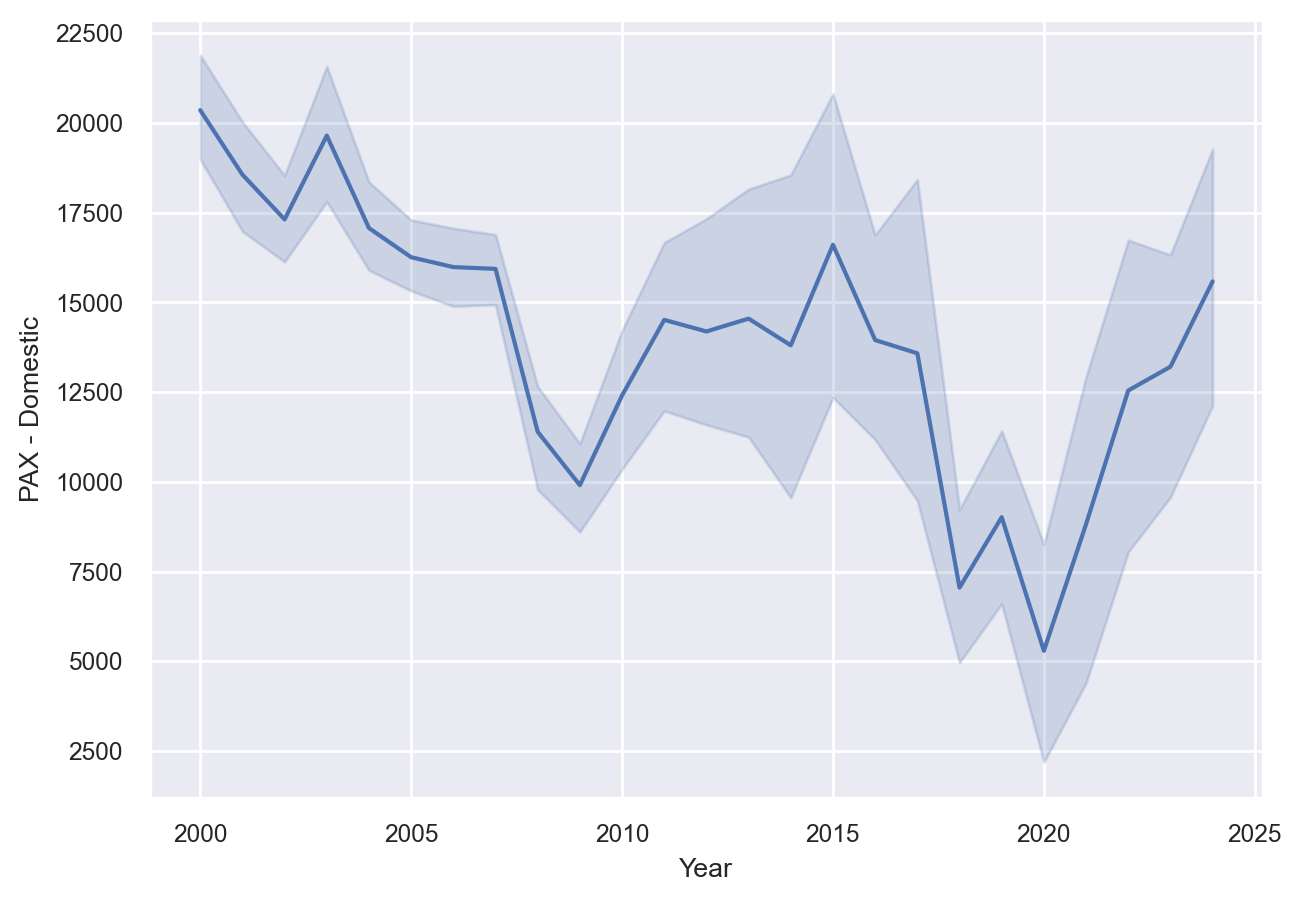

In [41]:
sns.lineplot(data=AOI_flights, x="Year", y="PAX - Domestic")

In [47]:
AOI_flights = df.query("Code == 'AOI'").sum().reset_index()

In [48]:
sns.lineplot(data=AOI_flights, x="Year", y="PAX - Domestic")

ValueError: Could not interpret value `Year` for parameter `x`

<AxesSubplot:xlabel='Year', ylabel='PAX - International'>

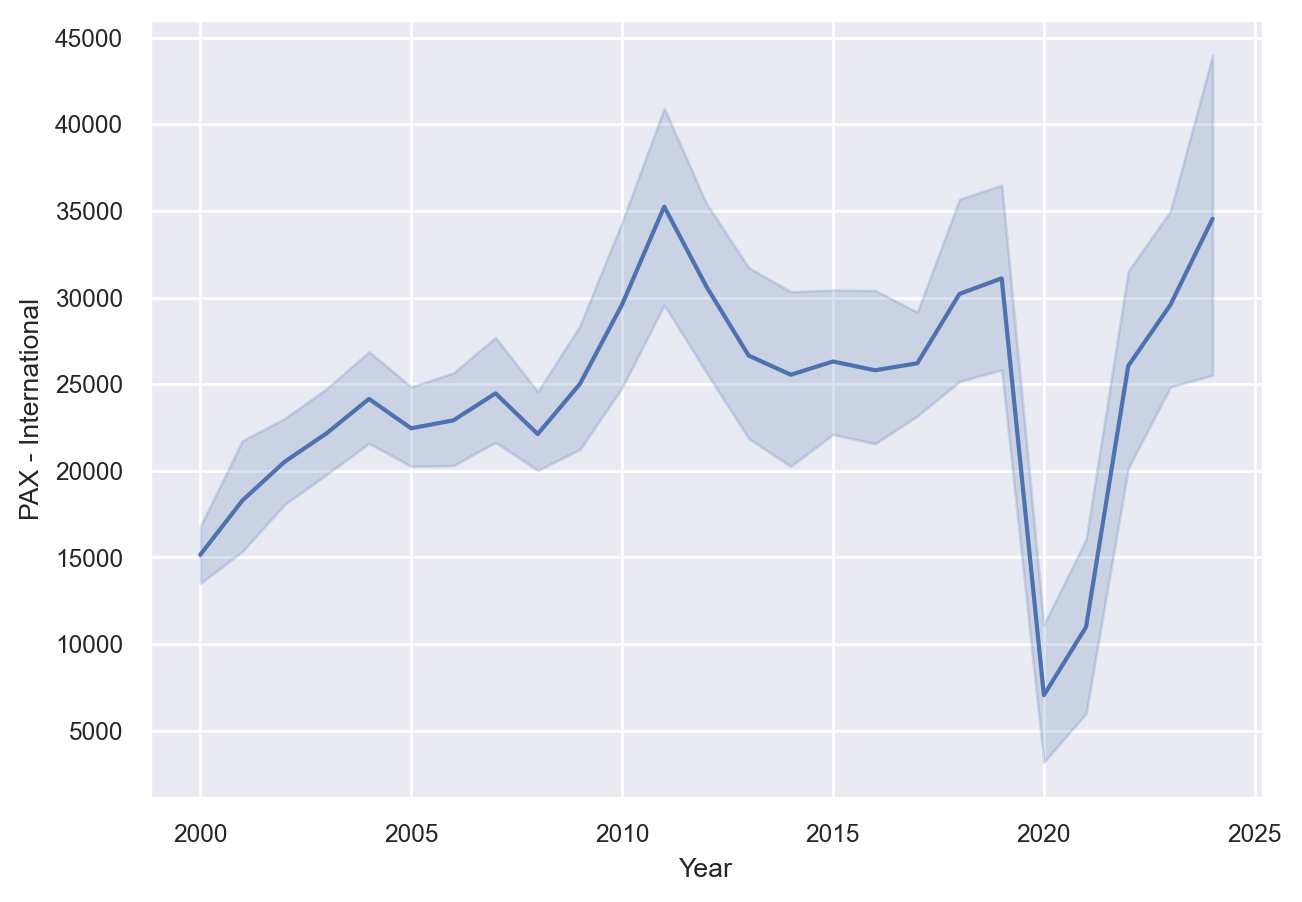

In [42]:
sns.lineplot(data=AOI_flights, x="Year", y="PAX - International")

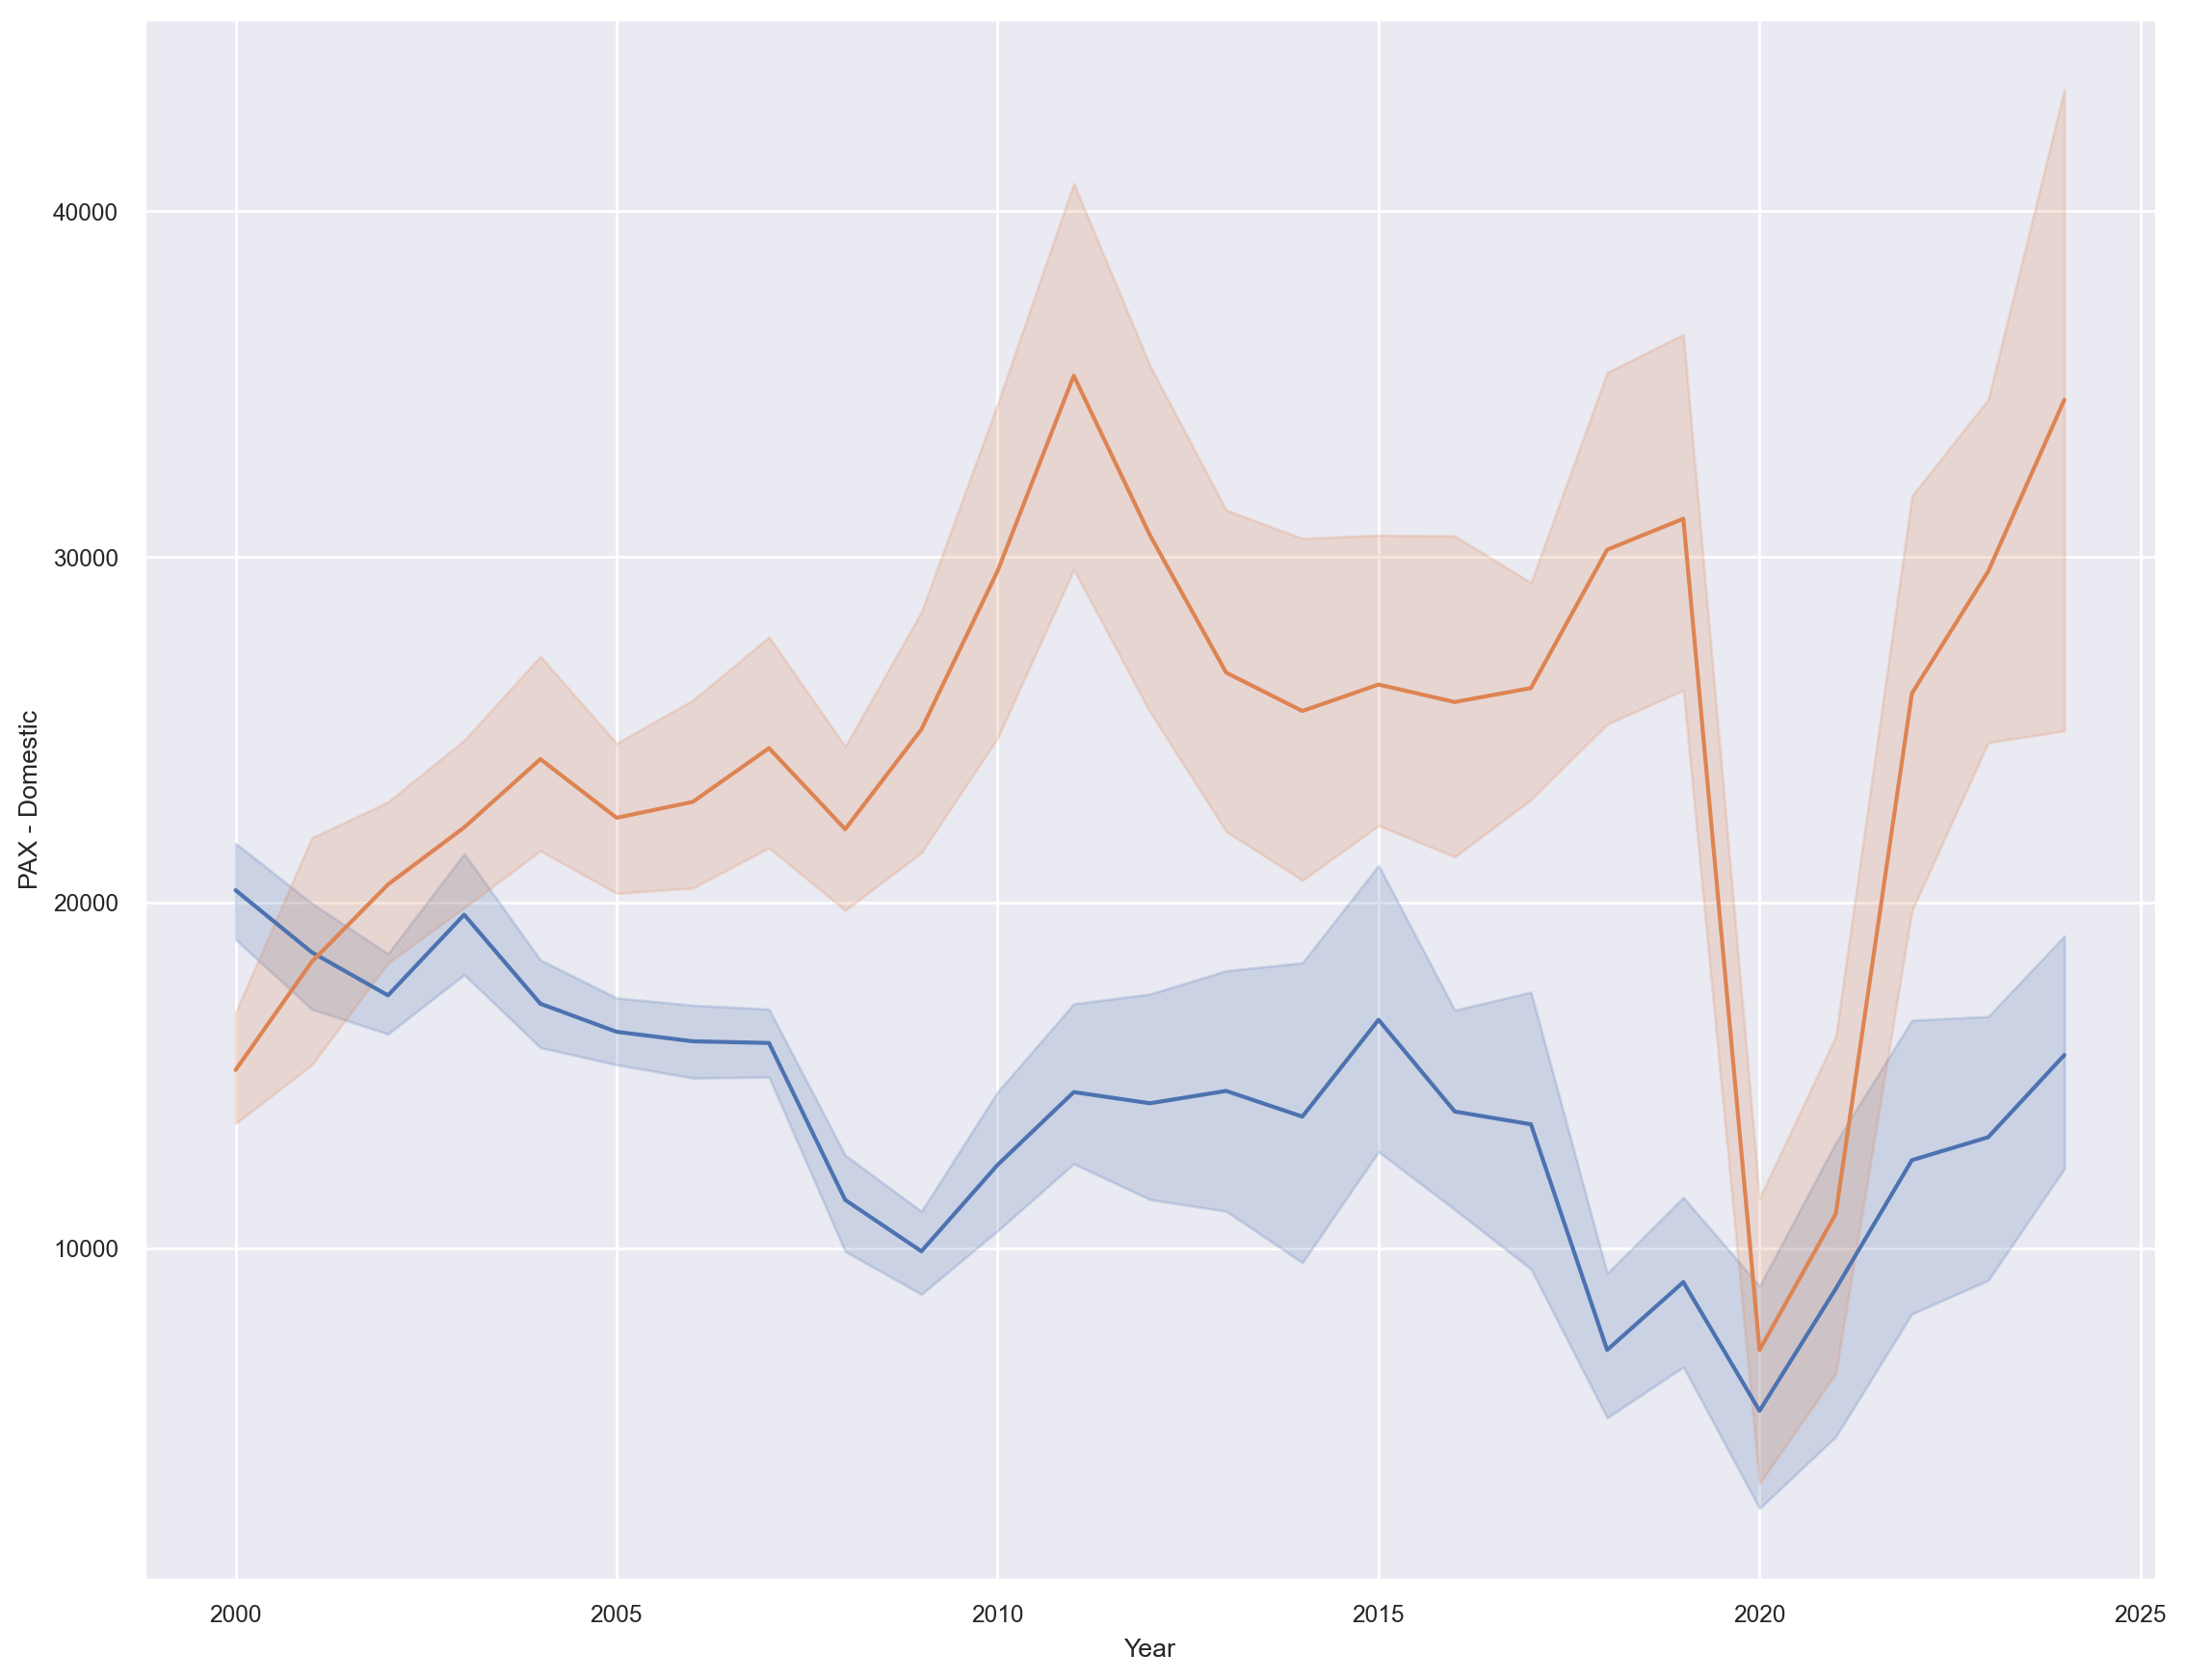

In [43]:
# plot the passengers time series
fig, ax = plt.subplots(figsize = (12,10))

plt.xticks(rotation = 0)
plt.ticklabel_format(style='plain', axis='y')
sns.lineplot(data=AOI_flights, x="Year", y="PAX - Domestic")
sns.lineplot(data=AOI_flights, x="Year", y="PAX - International")

plt.show()